In [76]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from datetime import datetime
from typing import Sequence
from torch.utils.data import random_split
#from d2l import torch as d2l
import matplotlib.pyplot as plt
import matplotlib.patches as patches


torch.manual_seed(123)



In [77]:
train_data = torch.load("localization_train.pt") 
val_data = torch.load("localization_val.pt")
test_data= torch.load("localization_test.pt")



In [8]:
#device = (torch.device("mps") if torch.backends.mps.is.available()
         #else torch.device("cpu"))
#device = torch.device("cpu")


In [78]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    
    n_batch = len(train_loader)
    
    # We'll store there the training loss for each epoch
    losses_train = []
    
    # Set the network in training mode
    model.train()
    
    # Re-initialize gradients, just in case the model has been inappropriately 
    # manipulated before the training
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1): 
        
        # Training loss for the current epoch
        loss_train = 0
        


        # Loop over our dataset (in batches the data loader creates for us)
        for imgs, labels in train_loader:
            
            
            #print("hello")
            
            # Feed a batch into our model
            outputs = model(imgs)
            
            # Compute the loss we wish to minimize 
            # Note that by default, it is the mean loss that is computed
            # (so entire_batch_loss / batch_size)
            
            
            loss = loss_fn(labels, outputs)
        
                
            #print(loss)
            
            # Perform the backward step. That is, compute the gradients of all parameters we want the network to learn
            loss.backward()
            
            # Update the model
            optimizer.step() 
            
            # Zero out gradients before the next round (or the end of training)
            optimizer.zero_grad() 

            # Update loss for this epoch
            # It is important to transform the loss to a number with .item()
            loss_train += loss.item()
            
        # Store current epoch loss. 
        losses_train.append(loss_train / n_batch)
        

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
            
    return losses_train

In [79]:
class MNIST_model(nn.Module):
    def __init__(self):
        super().__init__()  # to inherit the '__init__' method from the 'nn.Module' class
        # Add whatever you want here (e.g layers and activation functions)
        # The order and names don't matter here but it is easier to understand
        # if you go for Layer1, fun1, layer2, fun2, etc
        # Some conventions:
        # - conv stands for convolution
        # - pool for pooling
        # - fc for fully connected

        # 32*32*3: determined by our dataset: 32x32 RGB images
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features = 5*8*120 , out_features = 1000) # 5 is height 8 is width and 120 is nr channels.
        self.fc2 = nn.Linear(in_features = 1000 , out_features = 100)
        self.fc3 = nn.Linear(in_features = 100 , out_features = 10 +5) #C + 5 components
         
        
             

    def forward(self, x):
        # Now the order matters! 
        out = F.relu(self.conv1(x)) #F.relu is the activation function
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3(out))
        out = self.flat(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
        

In [80]:
def loss_fn(y_true, y_pred):
    
    LA = nn.BCEWithLogitsLoss(reduction='none')
    A = LA(y_pred[:,0], y_true[:,0])
        
    LB = nn.MSELoss(reduction='none')
    B = torch.sum(LB(y_pred[:,1:5], y_true[:,1:5]), dim = 1)
    LC = nn.CrossEntropyLoss(reduction='none')
    C = LC(y_pred[:,5:], y_true[:,5].long())
    
    #print(y_true[:,5])

    
        
    #print(A.shape)
    #print(B.shape)
    #print(y_true.shape)
    
        
        
        
        
   
        
    L_loc = torch.where(y_true[:,0] == 1, A+B+C, A)
    L_loc = torch.mean(L_loc)

    
    
    
    #print("A",A)
    #print("B",B)
    #print("C",C)
    
    
    return L_loc
        
        
        

In [81]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

deebug_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(val_data, range(100)), batch_size=128, shuffle=False)

In [13]:
torch.manual_seed(123)
model = MNIST_model()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

optimizer = optim.SGD(model.parameters(), lr=1e-2) #lr=1e-2 is the same as lr=0.01

loss_train = train(1, optimizer, model, loss_fn, train_loader)
loss_train

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


KeyboardInterrupt: 

In [82]:
def compute_iou(bb1, bb2):
    A_x0 = bb1[:,0] - bb1[:,2]/2
    A_y0 = bb1[:,1] - bb1[:,3]/2
    A_x1 = bb1[:,0] + bb1[:,2]/2
    A_y1 = bb1[:,1] + bb1[:,3]/2
    
    B_x0 = bb2[:,0] - bb2[:,2]/2
    B_y0 = bb2[:,1] - bb2[:,3]/2
    B_x1 = bb2[:,0] + bb2[:,2]/2
    B_y1 = bb2[:,1] + bb2[:,3]/2
    
    #compare each element of the tensors between A and B
    
    I_x0 = torch.max(A_x0,B_x0)
    I_y0 = torch.max(A_y0,B_y0)
    I_x1 = torch.min(A_x1,B_x1)
    I_y1 = torch.min(A_y1,B_y1)
    
    I_area = (I_x1 - I_x0)*(I_y1 - I_y0)
    
    A_area = (A_x1 - A_x0)*(A_y1 - A_y0)
    B_area = (B_x1 - B_x0)*(B_y1 - B_y0)
    
    U_area = A_area + B_area - I_area
    
    IoU = I_area / U_area
    
    return IoU
    
    
    
    
    
     

In [112]:
#def plot_boundingbox(bb1, bb2, img):
    
    #finding xy fro the bottum left corner for both bb1 and bb2
    
    fig, ax = plt.subplots()
    
    A_x = bb1[:,0] - bb1[:,2]/2
    A_y = bb1[:,1] + bb1[:,3]/2
    
    B_x = bb2[:,0] - bb2[:,2]/2
    B_y = bb2[:,1] + bb2[:,3]/2
    
    box1 = patches.Rectangle((A_x, A_y), bb1[:,2], bb1[:,3], linewidth=2, edgecolor = "r")
    box2 = patches.Rectangle((B_x, B_y), bb1[:,2], bb1[:,3], linewidth=2, edgecolor = "g")
    
    
    #plt.add_patch(box1)
    
    #ax.add_patch(box2)
    plt.axes.add_patch(box1)
    plt.axes.add_patch(box2)
    
    plt.imshow(img.squeeze(0))
    
    
    
    

    plt.show()
    

In [114]:
def plot_boundingbox(bb1, bb2, img):
    batch_size = img.shape[0]

    for b in range(batch_size):
        fig, ax = plt.subplots()

        A_x = torch.clamp(bb1[b, 0] - bb1[b, 2] / 2, 0, 1)
        A_y = torch.clamp(bb1[b, 1] - bb1[b, 3] / 2, 0, 1)

        B_x = torch.clamp(bb2[b, 0] - bb2[b, 2] / 2, 0, 1)
        B_y = torch.clamp(bb2[b, 1] - bb2[b, 3] / 2, 0, 1)

        print("Original BB1:", bb1[b])
        print("Clamped BB1:", A_x, A_y, bb1[b, 2], bb1[b, 3])

        print("Original BB2:", bb2[b])
        print("Clamped BB2:", B_x, B_y, bb2[b, 2], bb2[b, 3])

        box1 = patches.Rectangle((A_x, A_y), bb1[b, 2], bb1[b, 3], linewidth=2, edgecolor="r", facecolor='none')
        box2 = patches.Rectangle((B_x, B_y), bb2[b, 2], bb2[b, 3], linewidth=2, edgecolor="g", facecolor='none')

        box1_orig = patches.Rectangle((bb1[b, 0] - bb1[b, 2] / 2, bb1[b, 1] - bb1[b, 3] / 2), bb1[b, 2], bb1[b, 3], linewidth=2, edgecolor="m", facecolor='none')
        box2_orig = patches.Rectangle((bb2[b, 0] - bb2[b, 2] / 2, bb2[b, 1] - bb2[b, 3] / 2), bb2[b, 2], bb2[b, 3], linewidth=2, edgecolor="y", facecolor='none')

        ax.imshow(img[b].squeeze(0))
        ax.set_aspect(img[b].shape[1] / img[b].shape[2])


        ax.add_patch(box1)
        ax.add_patch(box2)
        ax.add_patch(box1_orig)
        ax.add_patch(box2_orig)

        plt.show()



In [16]:
# finn bilde 
# plt.imshow(img)
#plt.Rectangle()
# plt.show()

In [85]:
def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    tot_iou = 0
    totalpc1 = 0
    
    totalpcright = 0

    # We do not want gradients here, as we will not want to update the parameters.
    with torch.no_grad():
        for imgs, labels in loader:

            outputs = model(imgs)
            
            
            """
            if labels[0] == 0:
                if outputs[0] == 0:
                    correct += 1
            else:
                if outputs[0] == 0:
                    continue
                else:
                    if argmax(outputs[6:16]) == label[6]
                        correct += 1
                total_iou = iou(output[1:5], label[1:5]) 
                
                correct/ba
            
            """
            
            
            pc1 = torch.where(labels[:,0] == 1)[0]
            #print(pc1)
            
            
            _, predicted = torch.max(outputs[:,5:], dim=1) 
            predicted = torch.unsqueeze(predicted, 1)
            #print(labels.shape[0])
            total += labels.shape[0]
            totalpc1 += pc1.shape[0]
            correct += int((predicted[pc1] == labels[pc1,5:]).sum())
        
            
            #print(f"{outputs[:,1:5].shape} {labels[:,1:5].shape}")
        
            
            plot_boundingbox(outputs[pc1,1:5], labels[pc1,1:5], imgs)
            iou = compute_iou(outputs[pc1,1:5], labels[pc1,1:5])
            
            #correctpc = ((torch.sigmoid(predicted[:,0]) < 0.5) && (labels[:,0] == 0))[]
            #totalpcright += correctpc.shape[0]
            
            #print(total.shape[0])
            

    accpc = totalpcright/total
    print(accpc)

    acc =  ((correct / total) + (iou/totalpc1))/2

    #print(acc.shape)

    #print("Accuracy: {:.2f}".format(sum(acc)/acc.shape[0]))
          
    return acc
    

21:49:23.006958  |  Epoch 1  |  Training loss 3.402


AttributeError: 'function' object has no attribute 'add_patch'

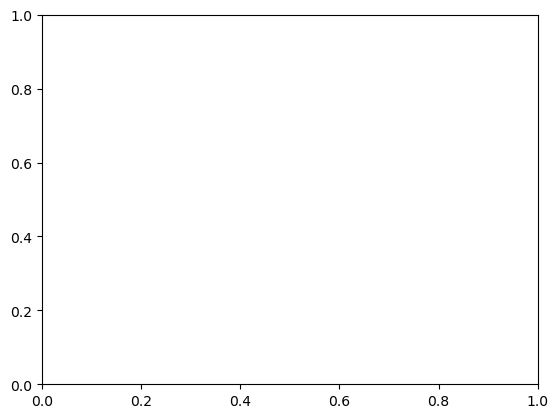

In [113]:
torch.manual_seed(123)

model_1 = MNIST_model()

train(1, optimizer, model_1, loss_fn, train_loader)

compute_accuracy(model_1, val_loader)


Original BB1: tensor([-0.0355,  0.0781,  0.0919,  0.0041])
Clamped BB1: tensor(0.) tensor(0.0760) tensor(0.0919) tensor(0.0041)
Original BB2: tensor([0.6167, 0.6250, 0.3667, 0.4583])
Clamped BB2: tensor(0.4333) tensor(0.3958) tensor(0.3667) tensor(0.4583)


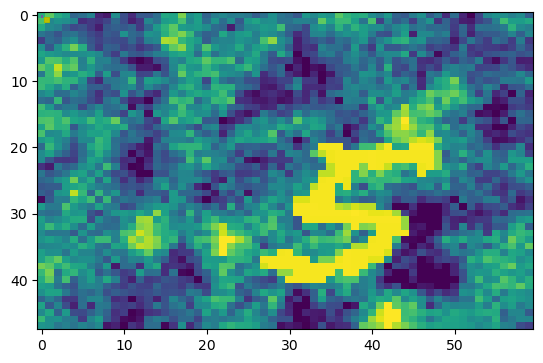

Original BB1: tensor([-0.0392,  0.0796,  0.0865,  0.0035])
Clamped BB1: tensor(0.) tensor(0.0778) tensor(0.0865) tensor(0.0035)
Original BB2: tensor([0.2667, 0.7812, 0.2333, 0.3125])
Clamped BB2: tensor(0.1500) tensor(0.6250) tensor(0.2333) tensor(0.3125)


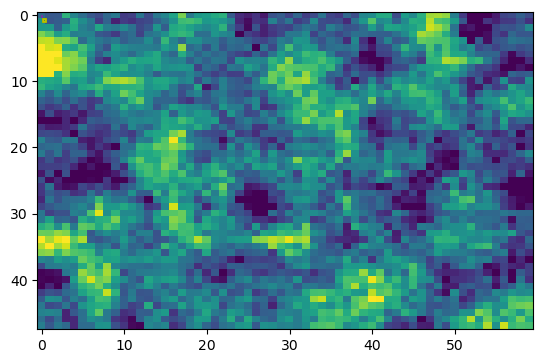

Original BB1: tensor([-0.0368,  0.0770,  0.0907,  0.0031])
Clamped BB1: tensor(0.) tensor(0.0755) tensor(0.0907) tensor(0.0031)
Original BB2: tensor([0.6500, 0.5521, 0.2333, 0.4375])
Clamped BB2: tensor(0.5333) tensor(0.3333) tensor(0.2333) tensor(0.4375)


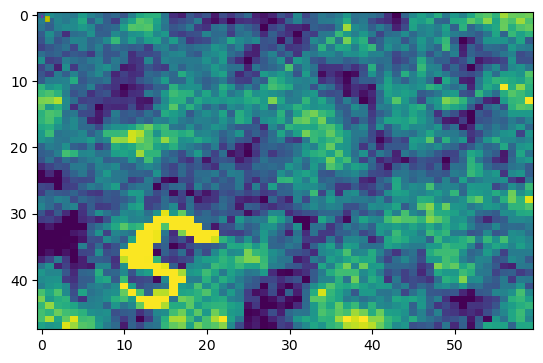

Original BB1: tensor([-0.0366,  0.0800,  0.0880,  0.0021])
Clamped BB1: tensor(0.) tensor(0.0789) tensor(0.0880) tensor(0.0021)
Original BB2: tensor([0.5583, 0.4792, 0.3833, 0.4583])
Clamped BB2: tensor(0.3667) tensor(0.2500) tensor(0.3833) tensor(0.4583)


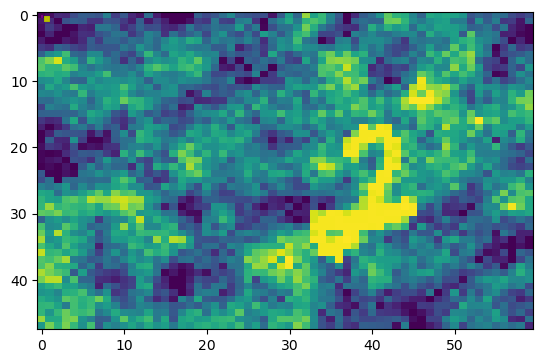

Original BB1: tensor([-0.0383,  0.0795,  0.0883,  0.0033])
Clamped BB1: tensor(0.) tensor(0.0779) tensor(0.0883) tensor(0.0033)
Original BB2: tensor([0.5000, 0.1979, 0.2333, 0.3125])
Clamped BB2: tensor(0.3833) tensor(0.0417) tensor(0.2333) tensor(0.3125)


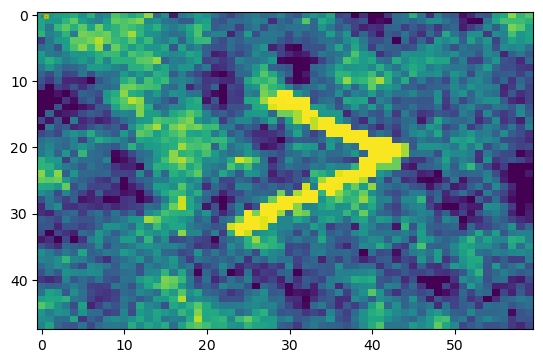

Original BB1: tensor([-0.0362,  0.0792,  0.0890,  0.0029])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0890) tensor(0.0029)
Original BB2: tensor([0.4333, 0.7083, 0.1667, 0.2917])
Clamped BB2: tensor(0.3500) tensor(0.5625) tensor(0.1667) tensor(0.2917)


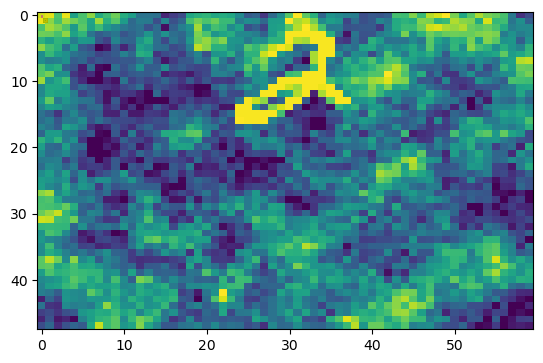

Original BB1: tensor([-0.0361,  0.0803,  0.0884,  0.0051])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0884) tensor(0.0051)
Original BB2: tensor([0.7083, 0.5625, 0.2167, 0.3333])
Clamped BB2: tensor(0.6000) tensor(0.3958) tensor(0.2167) tensor(0.3333)


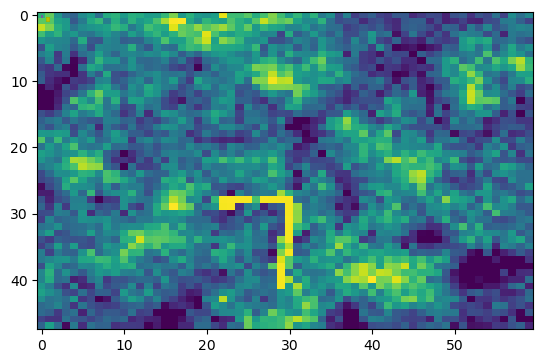

Original BB1: tensor([-0.0367,  0.0786,  0.0895,  0.0042])
Clamped BB1: tensor(0.) tensor(0.0765) tensor(0.0895) tensor(0.0042)
Original BB2: tensor([0.3167, 0.6667, 0.1667, 0.2917])
Clamped BB2: tensor(0.2333) tensor(0.5208) tensor(0.1667) tensor(0.2917)


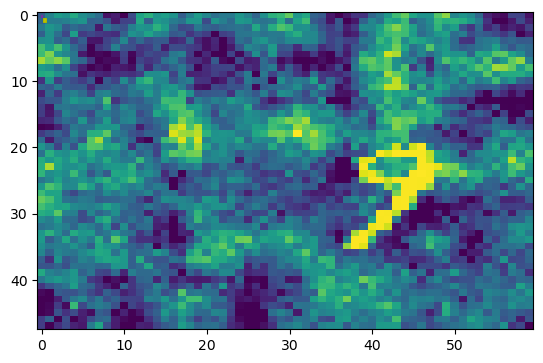

Original BB1: tensor([-0.0365,  0.0796,  0.0865,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0784) tensor(0.0865) tensor(0.0025)
Original BB2: tensor([0.1583, 0.6458, 0.3167, 0.3750])
Clamped BB2: tensor(0.) tensor(0.4583) tensor(0.3167) tensor(0.3750)


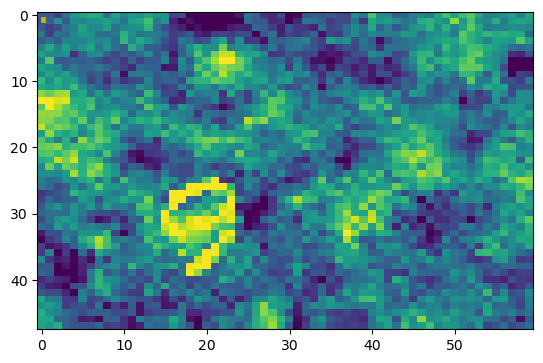

Original BB1: tensor([-0.0384,  0.0789,  0.0888,  0.0023])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0888) tensor(0.0023)
Original BB2: tensor([0.2000, 0.3646, 0.2333, 0.3958])
Clamped BB2: tensor(0.0833) tensor(0.1667) tensor(0.2333) tensor(0.3958)


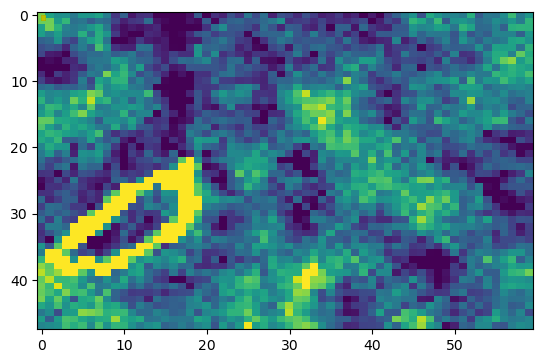

Original BB1: tensor([-0.0371,  0.0774,  0.0864,  0.0023])
Clamped BB1: tensor(0.) tensor(0.0762) tensor(0.0864) tensor(0.0023)
Original BB2: tensor([0.6167, 0.2500, 0.2333, 0.2917])
Clamped BB2: tensor(0.5000) tensor(0.1042) tensor(0.2333) tensor(0.2917)


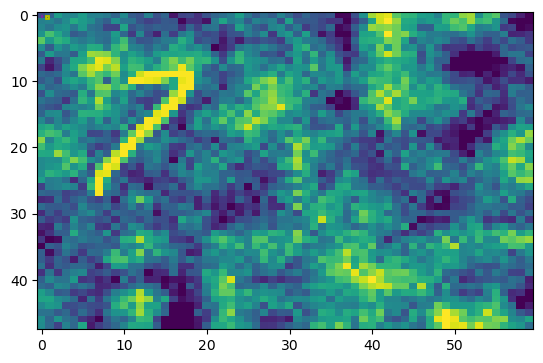

Original BB1: tensor([-0.0346,  0.0766,  0.0873,  0.0024])
Clamped BB1: tensor(0.) tensor(0.0754) tensor(0.0873) tensor(0.0024)
Original BB2: tensor([0.5083, 0.4167, 0.2833, 0.3750])
Clamped BB2: tensor(0.3667) tensor(0.2292) tensor(0.2833) tensor(0.3750)


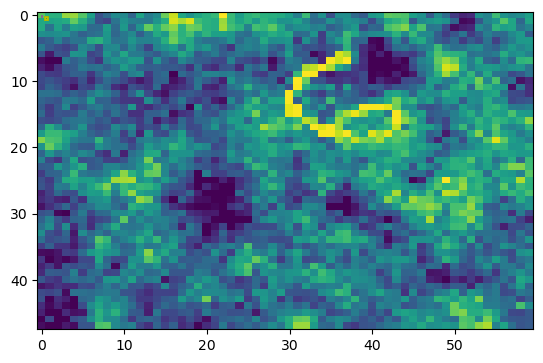

Original BB1: tensor([-0.0382,  0.0799,  0.0891,  0.0063])
Clamped BB1: tensor(0.) tensor(0.0767) tensor(0.0891) tensor(0.0063)
Original BB2: tensor([0.3167, 0.2292, 0.1667, 0.2500])
Clamped BB2: tensor(0.2333) tensor(0.1042) tensor(0.1667) tensor(0.2500)


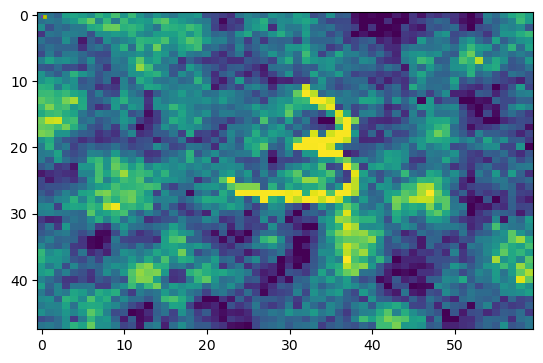

Original BB1: tensor([-0.0366,  0.0779,  0.0895,  0.0049])
Clamped BB1: tensor(0.) tensor(0.0755) tensor(0.0895) tensor(0.0049)
Original BB2: tensor([0.3583, 0.3958, 0.2833, 0.4583])
Clamped BB2: tensor(0.2167) tensor(0.1667) tensor(0.2833) tensor(0.4583)


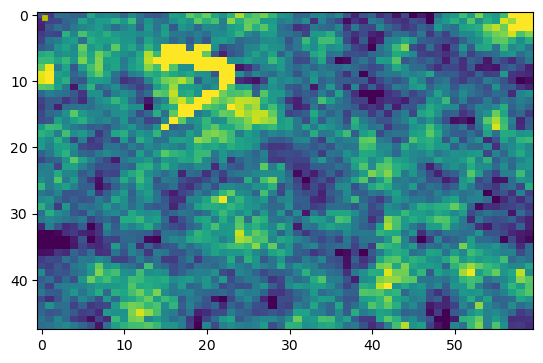

Original BB1: tensor([-0.0359,  0.0780,  0.0853,  0.0007])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0853) tensor(0.0007)
Original BB2: tensor([0.6583, 0.3021, 0.2833, 0.4375])
Clamped BB2: tensor(0.5167) tensor(0.0833) tensor(0.2833) tensor(0.4375)


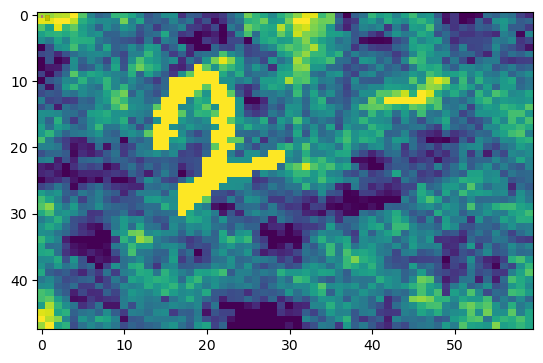

Original BB1: tensor([-0.0372,  0.0799,  0.0871,  0.0026])
Clamped BB1: tensor(0.) tensor(0.0786) tensor(0.0871) tensor(0.0026)
Original BB2: tensor([0.2083, 0.7396, 0.2833, 0.3542])
Clamped BB2: tensor(0.0667) tensor(0.5625) tensor(0.2833) tensor(0.3542)


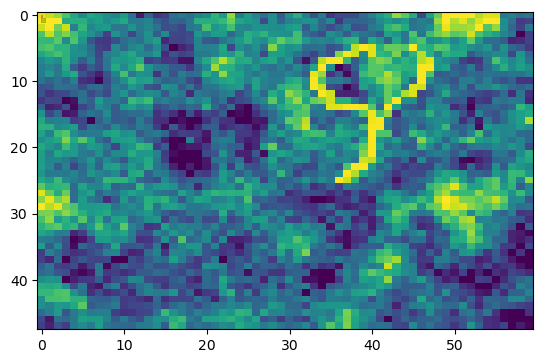

Original BB1: tensor([-0.0376,  0.0795,  0.0910,  0.0043])
Clamped BB1: tensor(0.) tensor(0.0774) tensor(0.0910) tensor(0.0043)
Original BB2: tensor([0.2667, 0.1979, 0.3000, 0.3958])
Clamped BB2: tensor(0.1167) tensor(0.) tensor(0.3000) tensor(0.3958)


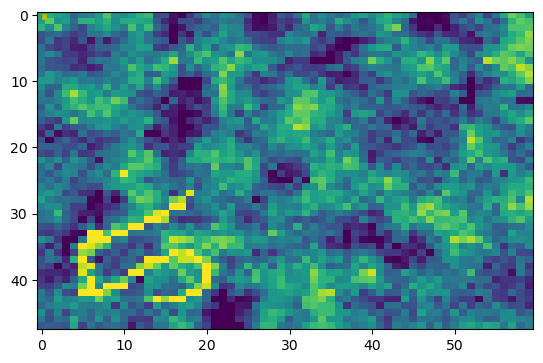

Original BB1: tensor([-0.0369,  0.0782,  0.0864,  0.0012])
Clamped BB1: tensor(0.) tensor(0.0776) tensor(0.0864) tensor(0.0012)
Original BB2: tensor([0.7000, 0.2708, 0.2000, 0.2917])
Clamped BB2: tensor(0.6000) tensor(0.1250) tensor(0.2000) tensor(0.2917)


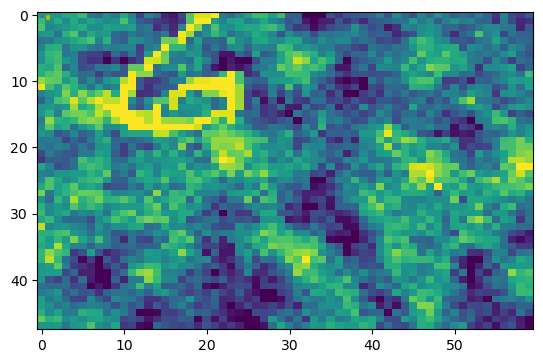

Original BB1: tensor([-0.0369,  0.0780,  0.0890,  0.0013])
Clamped BB1: tensor(0.) tensor(0.0774) tensor(0.0890) tensor(0.0013)
Original BB2: tensor([0.7583, 0.2083, 0.3500, 0.4167])
Clamped BB2: tensor(0.5833) tensor(0.) tensor(0.3500) tensor(0.4167)


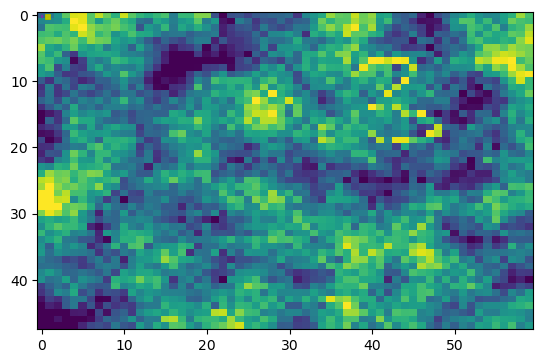

Original BB1: tensor([-0.0367,  0.0785,  0.0875,  0.0018])
Clamped BB1: tensor(0.) tensor(0.0776) tensor(0.0875) tensor(0.0018)
Original BB2: tensor([0.6083, 0.7917, 0.2167, 0.3333])
Clamped BB2: tensor(0.5000) tensor(0.6250) tensor(0.2167) tensor(0.3333)


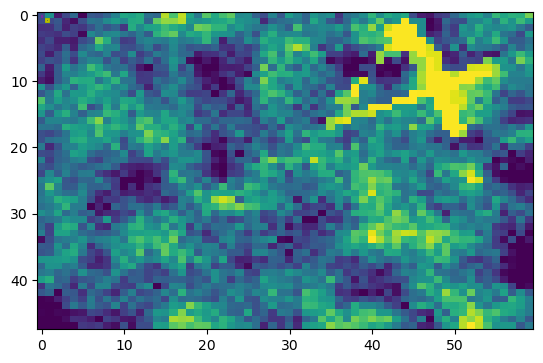

Original BB1: tensor([-0.0359,  0.0809,  0.0881,  0.0014])
Clamped BB1: tensor(0.) tensor(0.0802) tensor(0.0881) tensor(0.0014)
Original BB2: tensor([0.5917, 0.4062, 0.2500, 0.4375])
Clamped BB2: tensor(0.4667) tensor(0.1875) tensor(0.2500) tensor(0.4375)


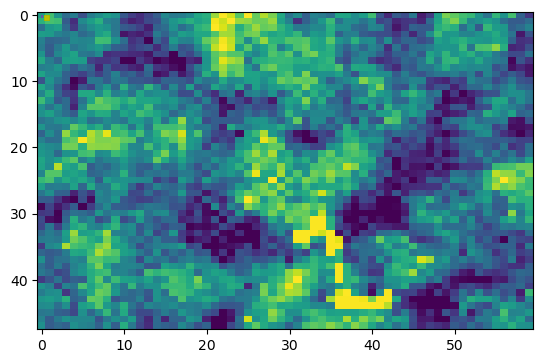

Original BB1: tensor([-0.0370,  0.0796,  0.0880,  0.0036])
Clamped BB1: tensor(0.) tensor(0.0778) tensor(0.0880) tensor(0.0036)
Original BB2: tensor([0.3917, 0.6875, 0.1167, 0.2917])
Clamped BB2: tensor(0.3333) tensor(0.5417) tensor(0.1167) tensor(0.2917)


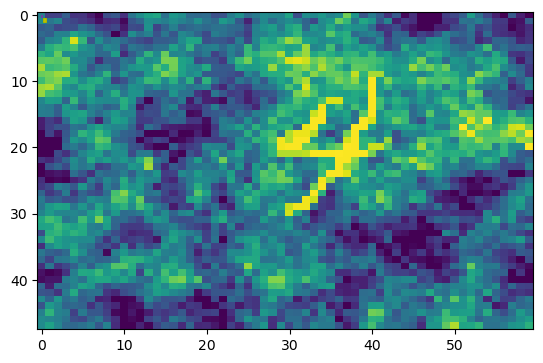

Original BB1: tensor([-0.0363,  0.0788,  0.0895,  0.0046])
Clamped BB1: tensor(0.) tensor(0.0765) tensor(0.0895) tensor(0.0046)
Original BB2: tensor([0.7333, 0.7500, 0.2667, 0.4583])
Clamped BB2: tensor(0.6000) tensor(0.5208) tensor(0.2667) tensor(0.4583)


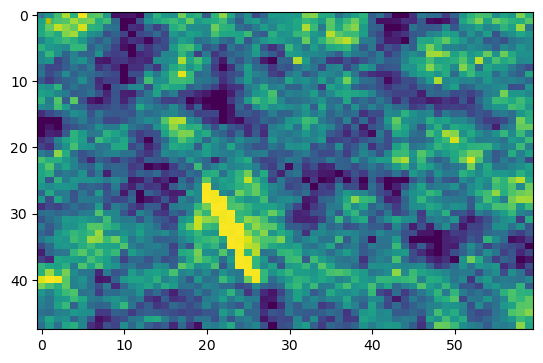

Original BB1: tensor([-0.0367,  0.0787,  0.0865,  0.0022])
Clamped BB1: tensor(0.) tensor(0.0776) tensor(0.0865) tensor(0.0022)
Original BB2: tensor([0.1750, 0.8021, 0.1167, 0.2708])
Clamped BB2: tensor(0.1167) tensor(0.6667) tensor(0.1167) tensor(0.2708)


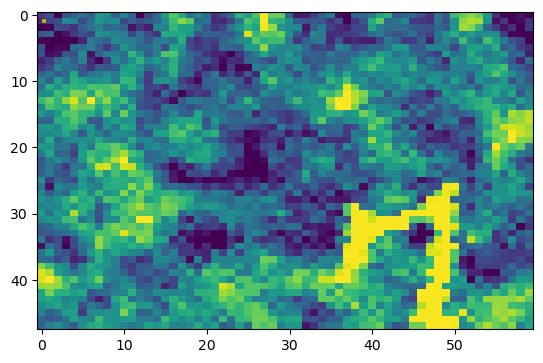

Original BB1: tensor([-0.0371,  0.0800,  0.0876,  0.0044])
Clamped BB1: tensor(0.) tensor(0.0778) tensor(0.0876) tensor(0.0044)
Original BB2: tensor([0.2500, 0.3333, 0.2333, 0.4167])
Clamped BB2: tensor(0.1333) tensor(0.1250) tensor(0.2333) tensor(0.4167)


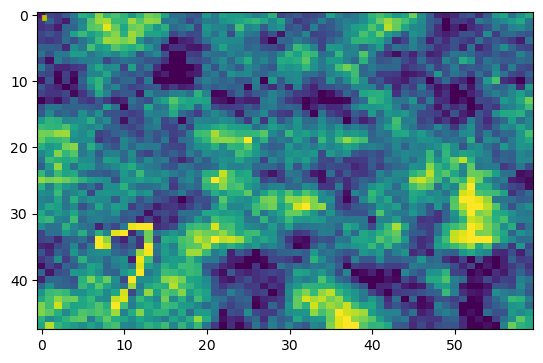

Original BB1: tensor([-0.0339,  0.0773,  0.0882,  0.0029])
Clamped BB1: tensor(0.) tensor(0.0759) tensor(0.0882) tensor(0.0029)
Original BB2: tensor([0.6500, 0.7188, 0.2000, 0.4375])
Clamped BB2: tensor(0.5500) tensor(0.5000) tensor(0.2000) tensor(0.4375)


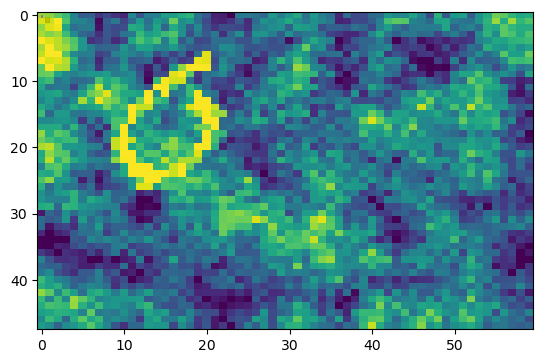

Original BB1: tensor([-0.0380,  0.0784,  0.0897,  0.0036])
Clamped BB1: tensor(0.) tensor(0.0766) tensor(0.0897) tensor(0.0036)
Original BB2: tensor([0.7250, 0.4271, 0.2500, 0.4375])
Clamped BB2: tensor(0.6000) tensor(0.2083) tensor(0.2500) tensor(0.4375)


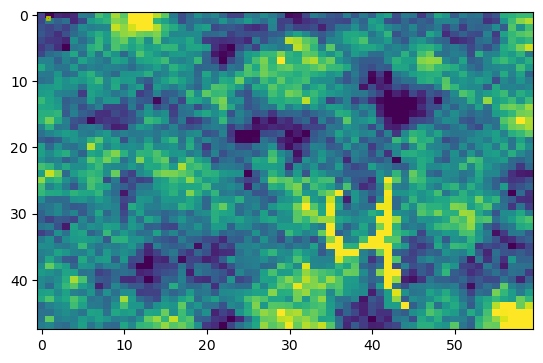

Original BB1: tensor([-0.0341,  0.0759,  0.0872,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0744) tensor(0.0872) tensor(0.0030)
Original BB2: tensor([0.3750, 0.2812, 0.2833, 0.4375])
Clamped BB2: tensor(0.2333) tensor(0.0625) tensor(0.2833) tensor(0.4375)


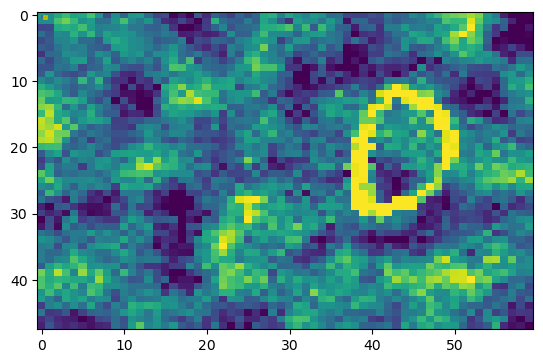

Original BB1: tensor([-0.0359,  0.0789,  0.0896,  0.0057])
Clamped BB1: tensor(0.) tensor(0.0760) tensor(0.0896) tensor(0.0057)
Original BB2: tensor([0.4083, 0.4688, 0.3167, 0.4375])
Clamped BB2: tensor(0.2500) tensor(0.2500) tensor(0.3167) tensor(0.4375)


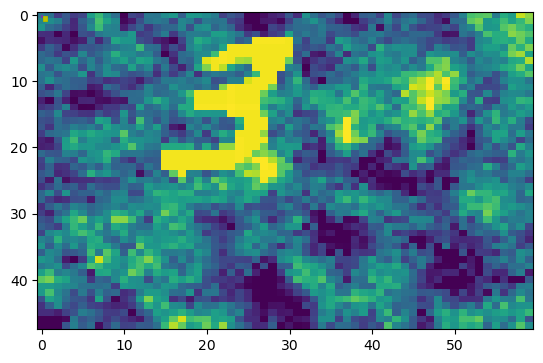

Original BB1: tensor([-0.0372,  0.0773,  0.0886,  0.0023])
Clamped BB1: tensor(0.) tensor(0.0762) tensor(0.0886) tensor(0.0023)
Original BB2: tensor([0.5833, 0.4688, 0.2667, 0.4375])
Clamped BB2: tensor(0.4500) tensor(0.2500) tensor(0.2667) tensor(0.4375)


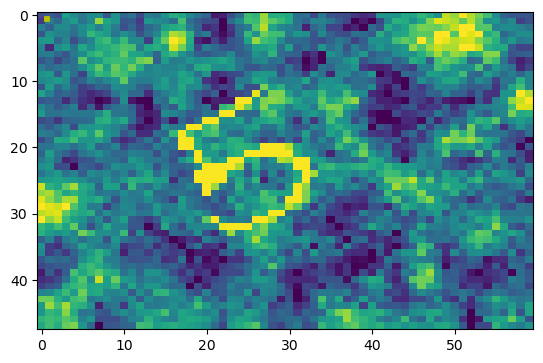

Original BB1: tensor([-0.0365,  0.0789,  0.0875,  0.0016])
Clamped BB1: tensor(0.) tensor(0.0781) tensor(0.0875) tensor(0.0016)
Original BB2: tensor([0.8083, 0.2292, 0.2833, 0.4167])
Clamped BB2: tensor(0.6667) tensor(0.0208) tensor(0.2833) tensor(0.4167)


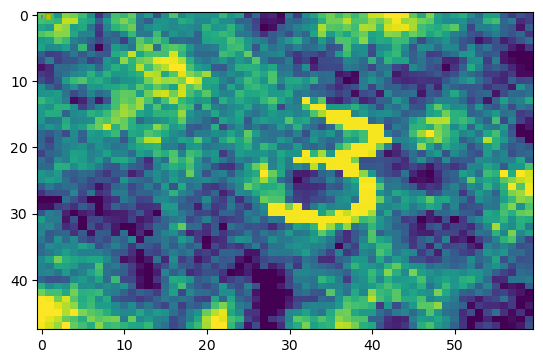

Original BB1: tensor([-0.0373,  0.0805,  0.0898,  0.0038])
Clamped BB1: tensor(0.) tensor(0.0786) tensor(0.0898) tensor(0.0038)
Original BB2: tensor([0.5250, 0.6458, 0.3500, 0.4167])
Clamped BB2: tensor(0.3500) tensor(0.4375) tensor(0.3500) tensor(0.4167)


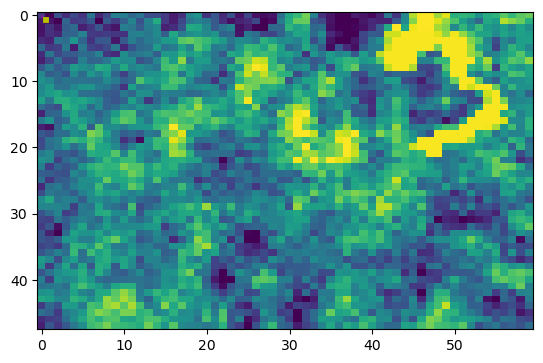

Original BB1: tensor([-0.0373,  0.0782,  0.0880,  0.0027])
Clamped BB1: tensor(0.) tensor(0.0768) tensor(0.0880) tensor(0.0027)
Original BB2: tensor([0.2750, 0.1875, 0.1500, 0.2917])
Clamped BB2: tensor(0.2000) tensor(0.0417) tensor(0.1500) tensor(0.2917)


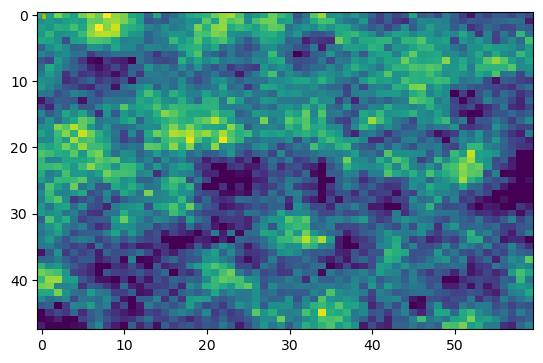

Original BB1: tensor([-0.0359,  0.0778,  0.0872,  0.0034])
Clamped BB1: tensor(0.) tensor(0.0761) tensor(0.0872) tensor(0.0034)
Original BB2: tensor([0.4583, 0.3438, 0.3167, 0.3542])
Clamped BB2: tensor(0.3000) tensor(0.1667) tensor(0.3167) tensor(0.3542)


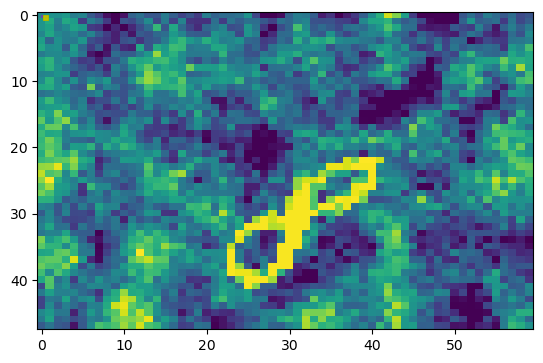

Original BB1: tensor([-0.0362,  0.0777,  0.0876,  0.0033])
Clamped BB1: tensor(0.) tensor(0.0761) tensor(0.0876) tensor(0.0033)
Original BB2: tensor([0.3750, 0.6667, 0.1833, 0.3333])
Clamped BB2: tensor(0.2833) tensor(0.5000) tensor(0.1833) tensor(0.3333)


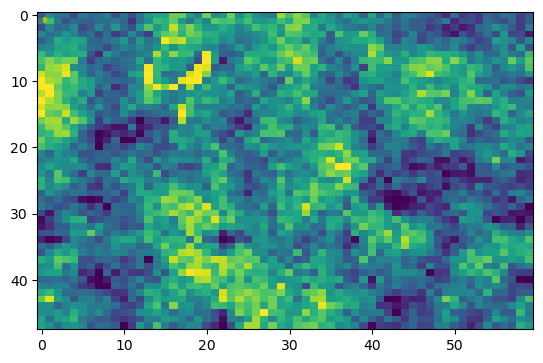

Original BB1: tensor([-0.0368,  0.0797,  0.0862,  0.0020])
Clamped BB1: tensor(0.) tensor(0.0787) tensor(0.0862) tensor(0.0020)
Original BB2: tensor([0.6500, 0.2396, 0.3000, 0.3542])
Clamped BB2: tensor(0.5000) tensor(0.0625) tensor(0.3000) tensor(0.3542)


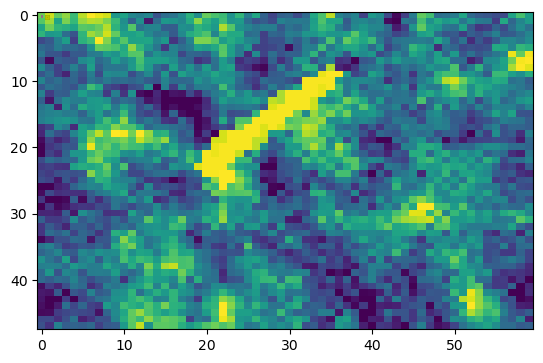

Original BB1: tensor([-0.0351,  0.0789,  0.0900,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0774) tensor(0.0900) tensor(0.0030)
Original BB2: tensor([0.4583, 0.6458, 0.3167, 0.4583])
Clamped BB2: tensor(0.3000) tensor(0.4167) tensor(0.3167) tensor(0.4583)


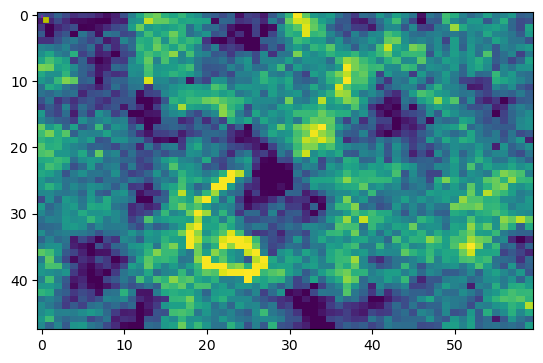

Original BB1: tensor([-0.0358,  0.0763,  0.0879,  0.0034])
Clamped BB1: tensor(0.) tensor(0.0746) tensor(0.0879) tensor(0.0034)
Original BB2: tensor([0.7250, 0.6042, 0.1833, 0.3333])
Clamped BB2: tensor(0.6333) tensor(0.4375) tensor(0.1833) tensor(0.3333)


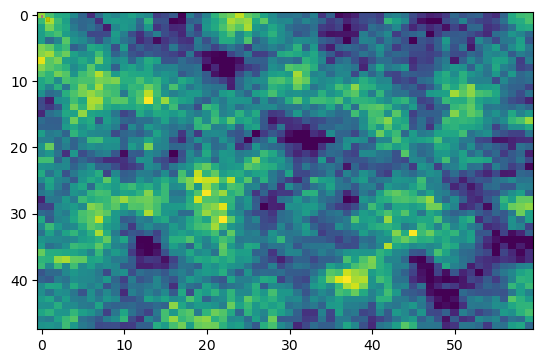

Original BB1: tensor([-0.0379,  0.0778,  0.0878,  0.0026])
Clamped BB1: tensor(0.) tensor(0.0766) tensor(0.0878) tensor(0.0026)
Original BB2: tensor([0.1750, 0.6146, 0.1500, 0.2708])
Clamped BB2: tensor(0.1000) tensor(0.4792) tensor(0.1500) tensor(0.2708)


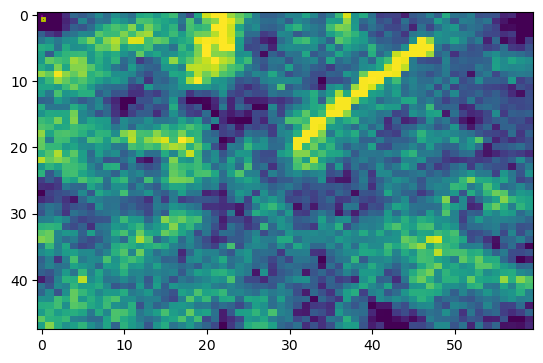

Original BB1: tensor([-0.0365,  0.0807,  0.0865,  0.0035])
Clamped BB1: tensor(0.) tensor(0.0790) tensor(0.0865) tensor(0.0035)
Original BB2: tensor([0.2583, 0.6354, 0.3833, 0.3958])
Clamped BB2: tensor(0.0667) tensor(0.4375) tensor(0.3833) tensor(0.3958)


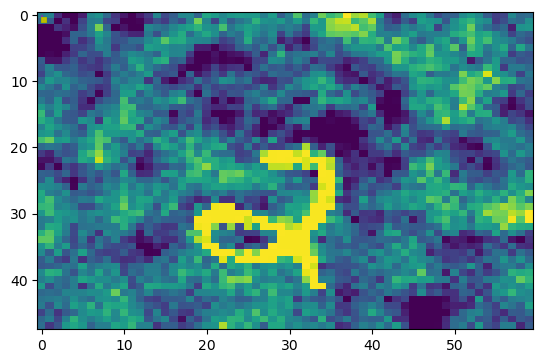

Original BB1: tensor([-0.0350,  0.0780,  0.0885,  0.0023])
Clamped BB1: tensor(0.) tensor(0.0769) tensor(0.0885) tensor(0.0023)
Original BB2: tensor([0.2333, 0.7396, 0.2000, 0.4375])
Clamped BB2: tensor(0.1333) tensor(0.5208) tensor(0.2000) tensor(0.4375)


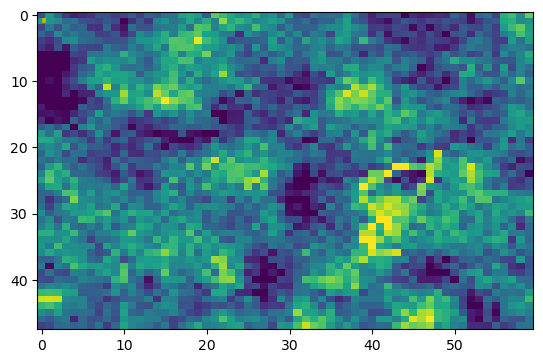

Original BB1: tensor([-0.0362,  0.0787,  0.0885, -0.0002])
Clamped BB1: tensor(0.) tensor(0.0788) tensor(0.0885) tensor(-0.0002)
Original BB2: tensor([0.6083, 0.6458, 0.2500, 0.4583])
Clamped BB2: tensor(0.4833) tensor(0.4167) tensor(0.2500) tensor(0.4583)


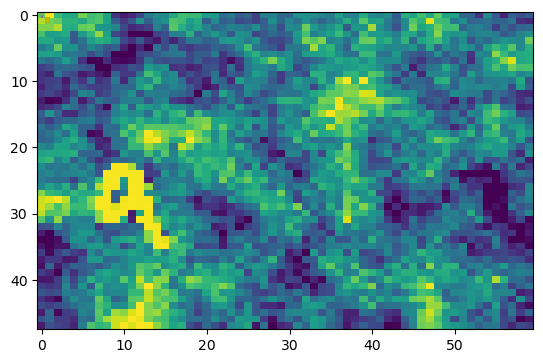

Original BB1: tensor([-0.0369,  0.0783,  0.0882,  0.0040])
Clamped BB1: tensor(0.) tensor(0.0762) tensor(0.0882) tensor(0.0040)
Original BB2: tensor([0.3667, 0.6562, 0.2667, 0.3125])
Clamped BB2: tensor(0.2333) tensor(0.5000) tensor(0.2667) tensor(0.3125)


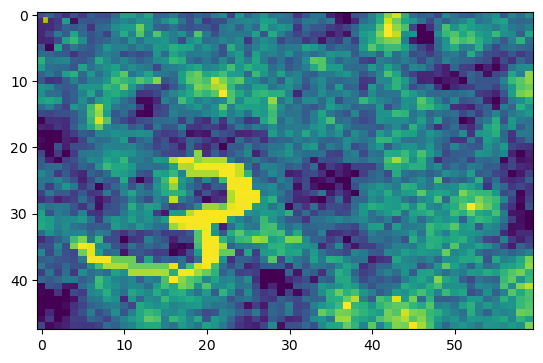

Original BB1: tensor([-0.0371,  0.0814,  0.0877,  0.0032])
Clamped BB1: tensor(0.) tensor(0.0798) tensor(0.0877) tensor(0.0032)
Original BB2: tensor([0.3667, 0.7708, 0.3667, 0.4167])
Clamped BB2: tensor(0.1833) tensor(0.5625) tensor(0.3667) tensor(0.4167)


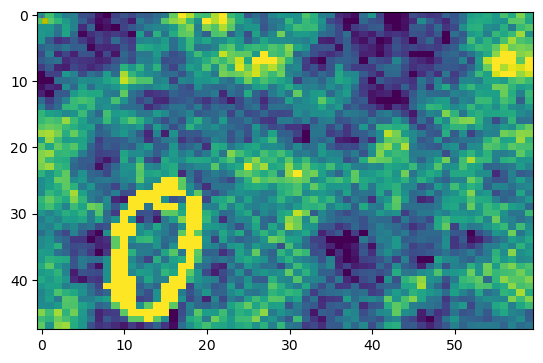

Original BB1: tensor([-0.0358,  0.0803,  0.0867,  0.0039])
Clamped BB1: tensor(0.) tensor(0.0784) tensor(0.0867) tensor(0.0039)
Original BB2: tensor([0.6583, 0.6354, 0.3833, 0.4375])
Clamped BB2: tensor(0.4667) tensor(0.4167) tensor(0.3833) tensor(0.4375)


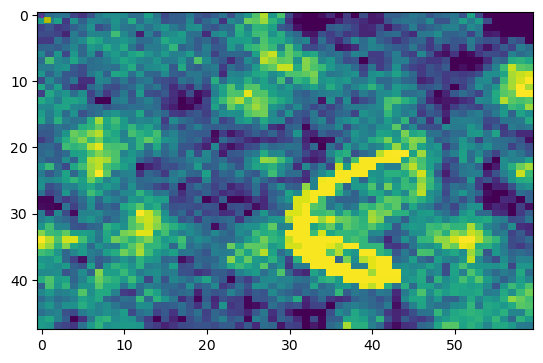

Original BB1: tensor([-0.0338,  0.0776,  0.0887,  0.0049])
Clamped BB1: tensor(0.) tensor(0.0752) tensor(0.0887) tensor(0.0049)
Original BB2: tensor([0.6417, 0.7812, 0.3167, 0.3958])
Clamped BB2: tensor(0.4833) tensor(0.5833) tensor(0.3167) tensor(0.3958)


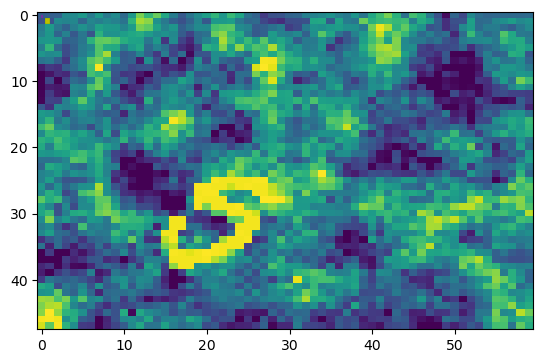

Original BB1: tensor([-0.0377,  0.0770,  0.0915,  0.0033])
Clamped BB1: tensor(0.) tensor(0.0754) tensor(0.0915) tensor(0.0033)
Original BB2: tensor([0.6167, 0.4375, 0.2333, 0.4167])
Clamped BB2: tensor(0.5000) tensor(0.2292) tensor(0.2333) tensor(0.4167)


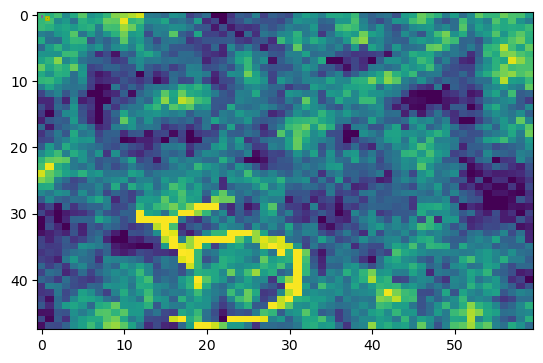

Original BB1: tensor([-0.0382,  0.0802,  0.0883,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0790) tensor(0.0883) tensor(0.0025)
Original BB2: tensor([0.4000, 0.2604, 0.3667, 0.4792])
Clamped BB2: tensor(0.2167) tensor(0.0208) tensor(0.3667) tensor(0.4792)


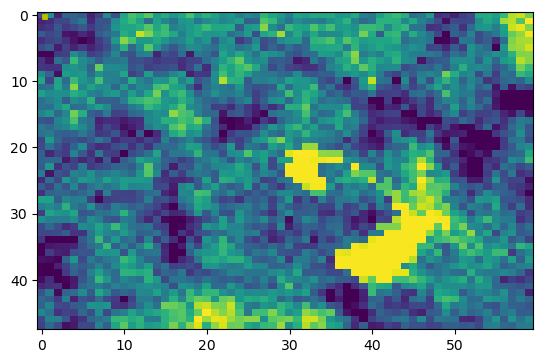

Original BB1: tensor([-0.0368,  0.0777,  0.0887,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0762) tensor(0.0887) tensor(0.0030)
Original BB2: tensor([0.1917, 0.4062, 0.1833, 0.2708])
Clamped BB2: tensor(0.1000) tensor(0.2708) tensor(0.1833) tensor(0.2708)


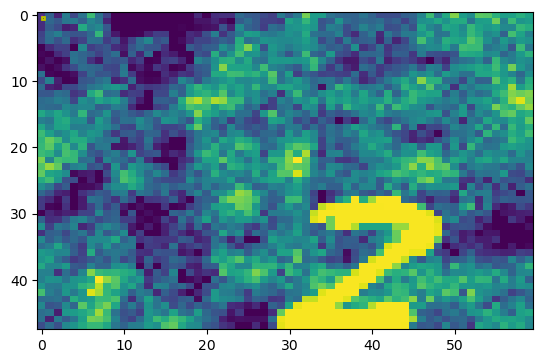

Original BB1: tensor([-0.0379,  0.0794,  0.0881,  0.0021])
Clamped BB1: tensor(0.) tensor(0.0784) tensor(0.0881) tensor(0.0021)
Original BB2: tensor([0.3250, 0.7083, 0.2833, 0.3333])
Clamped BB2: tensor(0.1833) tensor(0.5417) tensor(0.2833) tensor(0.3333)


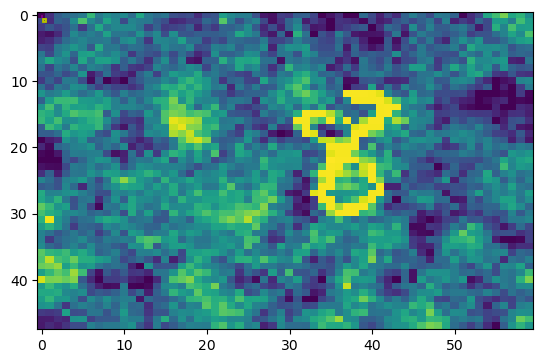

Original BB1: tensor([-0.0355,  0.0813,  0.0854,  0.0021])
Clamped BB1: tensor(0.) tensor(0.0802) tensor(0.0854) tensor(0.0021)
Original BB2: tensor([0.5667, 0.3646, 0.2667, 0.3542])
Clamped BB2: tensor(0.4333) tensor(0.1875) tensor(0.2667) tensor(0.3542)


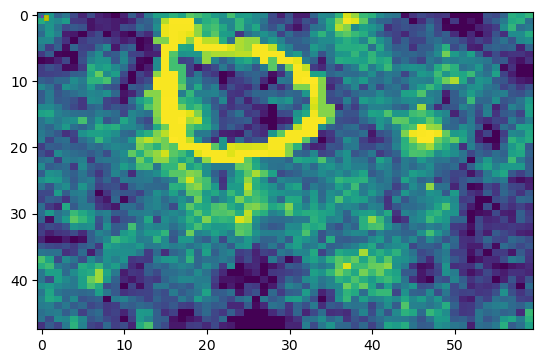

Original BB1: tensor([-0.0359,  0.0768,  0.0875,  0.0047])
Clamped BB1: tensor(0.) tensor(0.0745) tensor(0.0875) tensor(0.0047)
Original BB2: tensor([0.8000, 0.4479, 0.2667, 0.4792])
Clamped BB2: tensor(0.6667) tensor(0.2083) tensor(0.2667) tensor(0.4792)


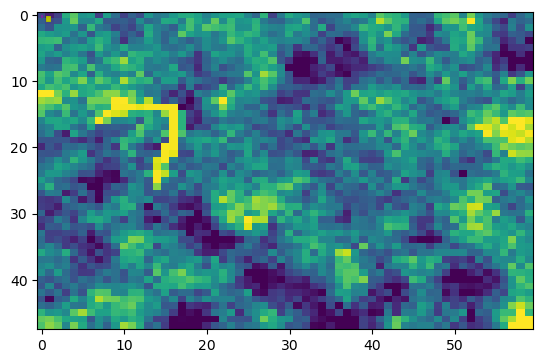

Original BB1: tensor([-0.0376,  0.0754,  0.0905,  0.0022])
Clamped BB1: tensor(0.) tensor(0.0743) tensor(0.0905) tensor(0.0022)
Original BB2: tensor([0.6083, 0.6667, 0.3167, 0.4583])
Clamped BB2: tensor(0.4500) tensor(0.4375) tensor(0.3167) tensor(0.4583)


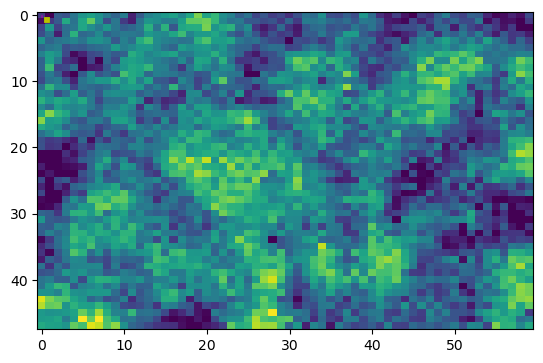

Original BB1: tensor([-0.0385,  0.0784,  0.0881,  0.0022])
Clamped BB1: tensor(0.) tensor(0.0773) tensor(0.0881) tensor(0.0022)
Original BB2: tensor([0.1833, 0.6562, 0.3000, 0.3125])
Clamped BB2: tensor(0.0333) tensor(0.5000) tensor(0.3000) tensor(0.3125)


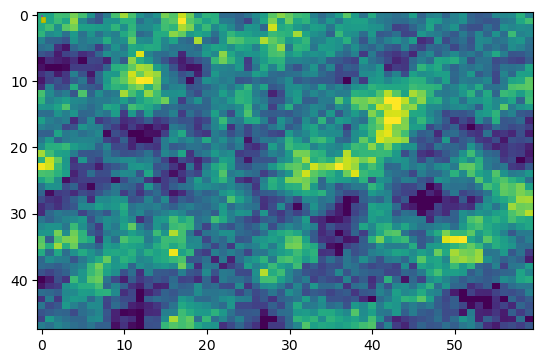

Original BB1: tensor([-0.0347,  0.0791,  0.0902,  0.0017])
Clamped BB1: tensor(0.) tensor(0.0783) tensor(0.0902) tensor(0.0017)
Original BB2: tensor([0.5917, 0.5729, 0.3500, 0.4792])
Clamped BB2: tensor(0.4167) tensor(0.3333) tensor(0.3500) tensor(0.4792)


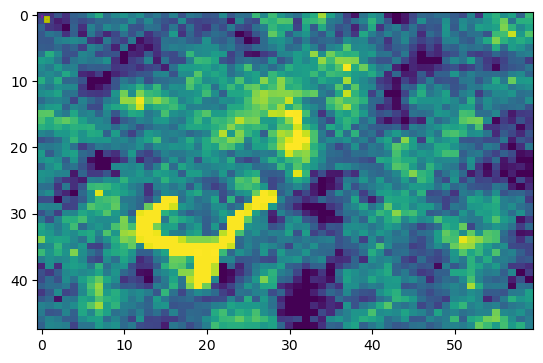

Original BB1: tensor([-0.0373,  0.0807,  0.0861,  0.0019])
Clamped BB1: tensor(0.) tensor(0.0798) tensor(0.0861) tensor(0.0019)
Original BB2: tensor([0.7000, 0.3438, 0.2000, 0.3125])
Clamped BB2: tensor(0.6000) tensor(0.1875) tensor(0.2000) tensor(0.3125)


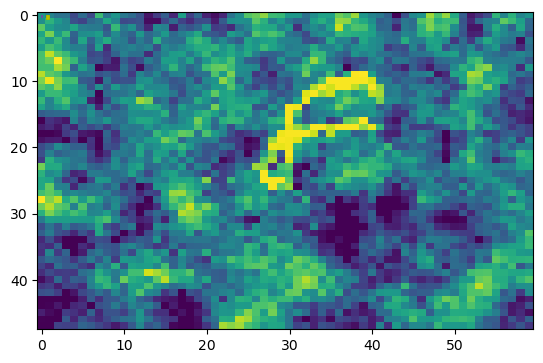

Original BB1: tensor([-0.0372,  0.0774,  0.0890,  0.0047])
Clamped BB1: tensor(0.) tensor(0.0751) tensor(0.0890) tensor(0.0047)
Original BB2: tensor([0.3167, 0.5000, 0.2333, 0.3750])
Clamped BB2: tensor(0.2000) tensor(0.3125) tensor(0.2333) tensor(0.3750)


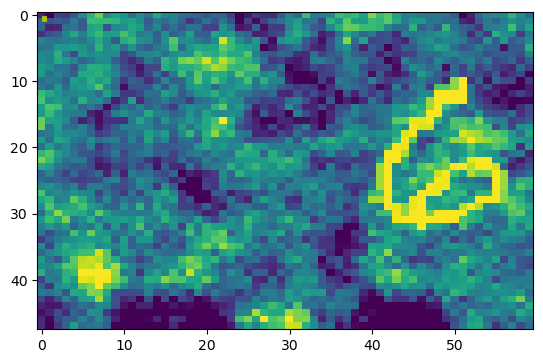

Original BB1: tensor([-0.0355,  0.0780,  0.0895,  0.0055])
Clamped BB1: tensor(0.) tensor(0.0753) tensor(0.0895) tensor(0.0055)
Original BB2: tensor([0.5583, 0.6979, 0.3167, 0.4375])
Clamped BB2: tensor(0.4000) tensor(0.4792) tensor(0.3167) tensor(0.4375)


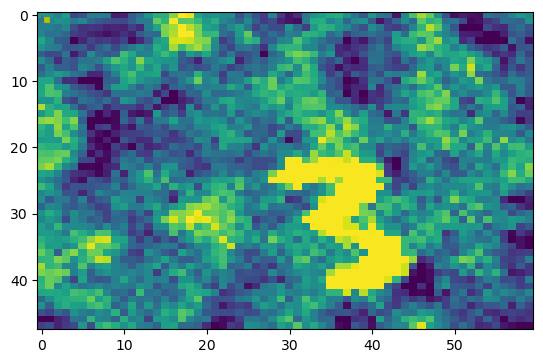

Original BB1: tensor([-0.0362,  0.0793,  0.0902,  0.0026])
Clamped BB1: tensor(0.) tensor(0.0780) tensor(0.0902) tensor(0.0026)
Original BB2: tensor([0.6500, 0.4062, 0.3000, 0.3958])
Clamped BB2: tensor(0.5000) tensor(0.2083) tensor(0.3000) tensor(0.3958)


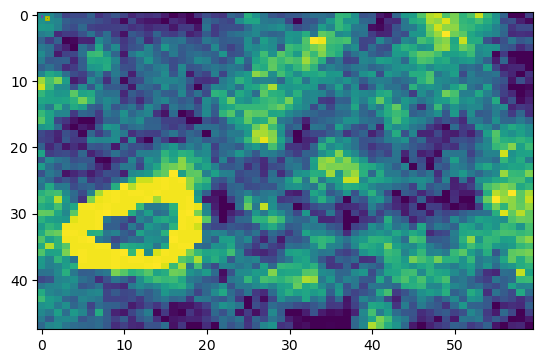

Original BB1: tensor([-0.0369,  0.0801,  0.0860,  0.0016])
Clamped BB1: tensor(0.) tensor(0.0793) tensor(0.0860) tensor(0.0016)
Original BB2: tensor([0.4667, 0.2292, 0.3000, 0.4167])
Clamped BB2: tensor(0.3167) tensor(0.0208) tensor(0.3000) tensor(0.4167)


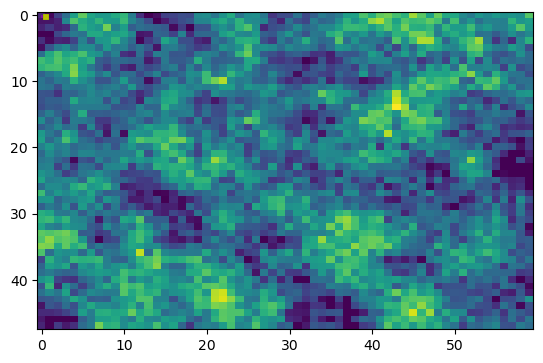

Original BB1: tensor([-0.0362,  0.0801,  0.0892,  0.0031])
Clamped BB1: tensor(0.) tensor(0.0786) tensor(0.0892) tensor(0.0031)
Original BB2: tensor([0.3917, 0.6875, 0.2500, 0.3750])
Clamped BB2: tensor(0.2667) tensor(0.5000) tensor(0.2500) tensor(0.3750)


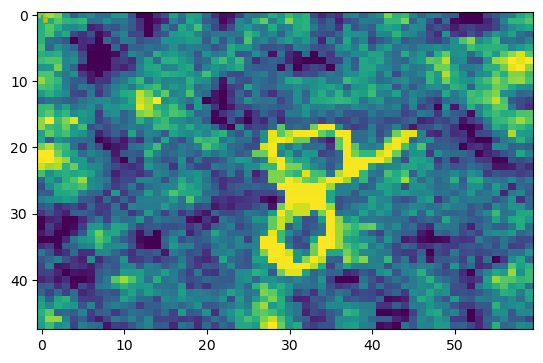

Original BB1: tensor([-0.0390,  0.0815,  0.0903,  0.0038])
Clamped BB1: tensor(0.) tensor(0.0796) tensor(0.0903) tensor(0.0038)
Original BB2: tensor([0.7583, 0.2917, 0.2167, 0.4583])
Clamped BB2: tensor(0.6500) tensor(0.0625) tensor(0.2167) tensor(0.4583)


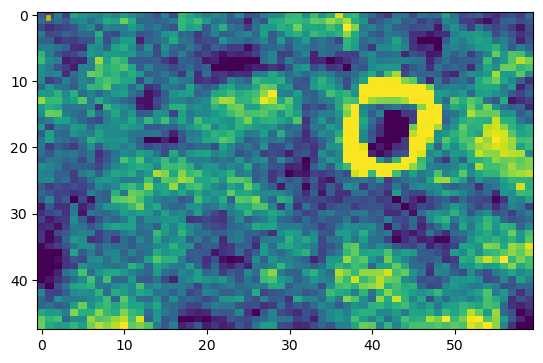

Original BB1: tensor([-0.0381,  0.0805,  0.0881,  0.0031])
Clamped BB1: tensor(0.) tensor(0.0790) tensor(0.0881) tensor(0.0031)
Original BB2: tensor([0.2333, 0.3750, 0.2333, 0.3333])
Clamped BB2: tensor(0.1167) tensor(0.2083) tensor(0.2333) tensor(0.3333)


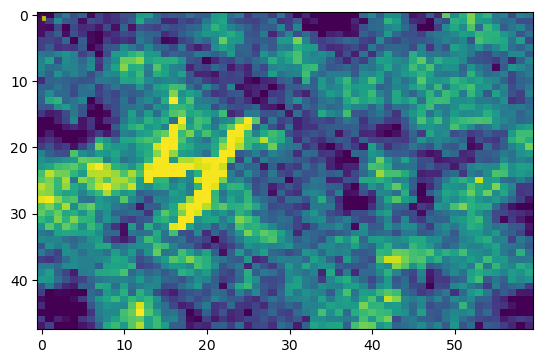

Original BB1: tensor([-0.0354,  0.0768,  0.0914,  0.0044])
Clamped BB1: tensor(0.) tensor(0.0746) tensor(0.0914) tensor(0.0044)
Original BB2: tensor([0.4750, 0.5208, 0.3833, 0.3333])
Clamped BB2: tensor(0.2833) tensor(0.3542) tensor(0.3833) tensor(0.3333)


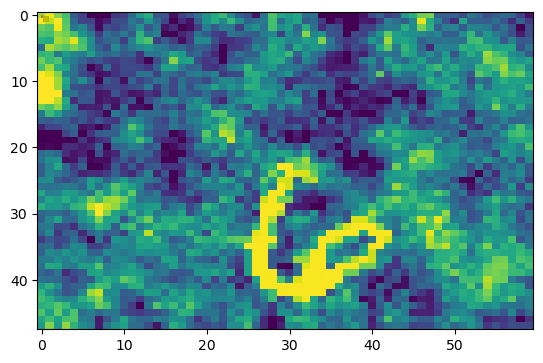

Original BB1: tensor([-0.0376,  0.0809,  0.0874,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0795) tensor(0.0874) tensor(0.0030)
Original BB2: tensor([0.3750, 0.4583, 0.2167, 0.2500])
Clamped BB2: tensor(0.2667) tensor(0.3333) tensor(0.2167) tensor(0.2500)


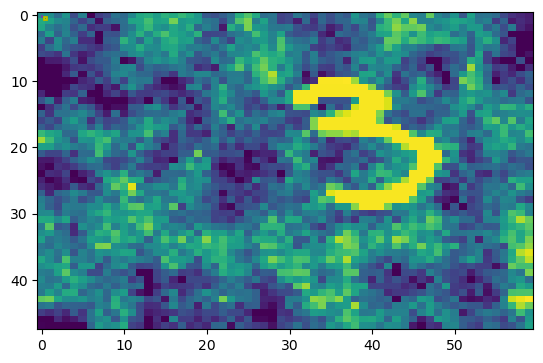

Original BB1: tensor([-0.0371,  0.0772,  0.0878,  0.0018])
Clamped BB1: tensor(0.) tensor(0.0763) tensor(0.0878) tensor(0.0018)
Original BB2: tensor([0.1500, 0.4896, 0.2333, 0.4375])
Clamped BB2: tensor(0.0333) tensor(0.2708) tensor(0.2333) tensor(0.4375)


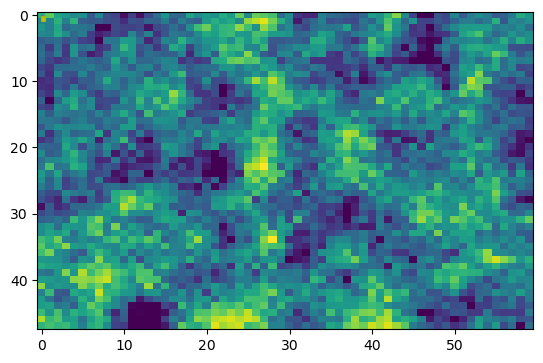

Original BB1: tensor([-0.0376,  0.0807,  0.0853,  0.0039])
Clamped BB1: tensor(0.) tensor(0.0788) tensor(0.0853) tensor(0.0039)
Original BB2: tensor([0.2417, 0.6875, 0.3500, 0.5000])
Clamped BB2: tensor(0.0667) tensor(0.4375) tensor(0.3500) tensor(0.5000)


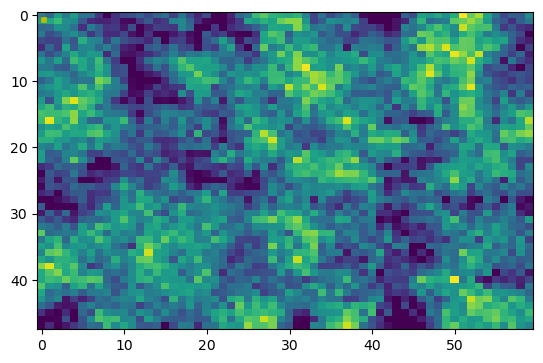

Original BB1: tensor([-0.0369,  0.0768,  0.0890,  0.0020])
Clamped BB1: tensor(0.) tensor(0.0759) tensor(0.0890) tensor(0.0020)
Original BB2: tensor([0.6500, 0.4375, 0.3000, 0.3750])
Clamped BB2: tensor(0.5000) tensor(0.2500) tensor(0.3000) tensor(0.3750)


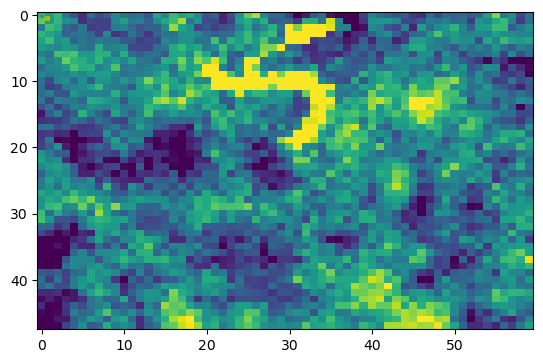

Original BB1: tensor([-0.0387,  0.0794,  0.0887,  0.0035])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0887) tensor(0.0035)
Original BB2: tensor([0.2250, 0.7812, 0.2167, 0.3958])
Clamped BB2: tensor(0.1167) tensor(0.5833) tensor(0.2167) tensor(0.3958)


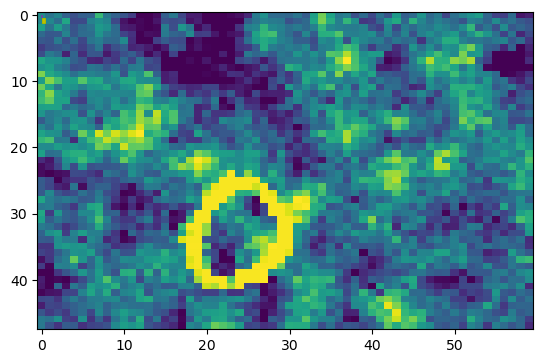

Original BB1: tensor([-0.0373,  0.0777,  0.0871,  0.0029])
Clamped BB1: tensor(0.) tensor(0.0762) tensor(0.0871) tensor(0.0029)
Original BB2: tensor([0.1833, 0.7812, 0.2667, 0.3125])
Clamped BB2: tensor(0.0500) tensor(0.6250) tensor(0.2667) tensor(0.3125)


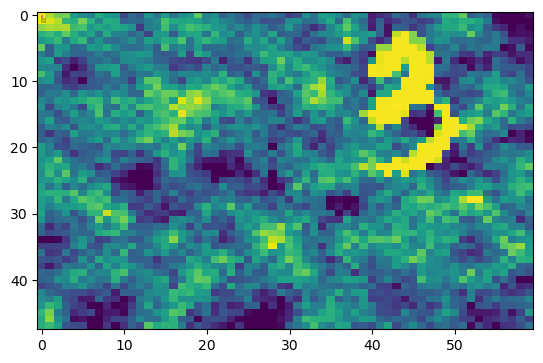

Original BB1: tensor([-0.0367,  0.0804,  0.0872,  0.0046])
Clamped BB1: tensor(0.) tensor(0.0780) tensor(0.0872) tensor(0.0046)
Original BB2: tensor([0.7667, 0.2292, 0.1667, 0.3333])
Clamped BB2: tensor(0.6833) tensor(0.0625) tensor(0.1667) tensor(0.3333)


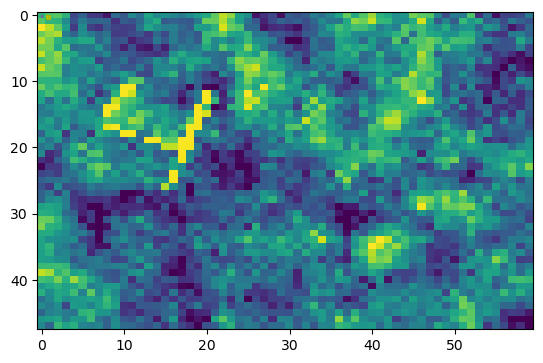

Original BB1: tensor([-0.0362,  0.0804,  0.0876,  0.0037])
Clamped BB1: tensor(0.) tensor(0.0786) tensor(0.0876) tensor(0.0037)
Original BB2: tensor([0.3000, 0.2188, 0.3333, 0.3542])
Clamped BB2: tensor(0.1333) tensor(0.0417) tensor(0.3333) tensor(0.3542)


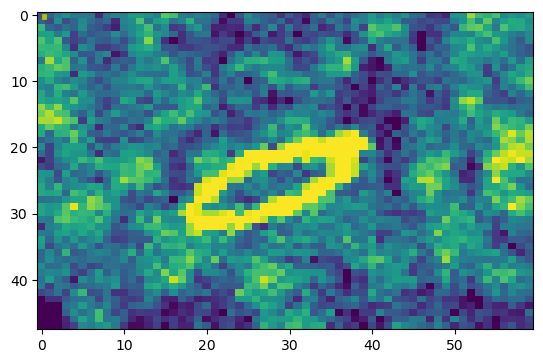

Original BB1: tensor([-0.0358,  0.0789,  0.0869,  0.0028])
Clamped BB1: tensor(0.) tensor(0.0775) tensor(0.0869) tensor(0.0028)
Original BB2: tensor([0.2250, 0.2188, 0.3500, 0.4375])
Clamped BB2: tensor(0.0500) tensor(0.) tensor(0.3500) tensor(0.4375)


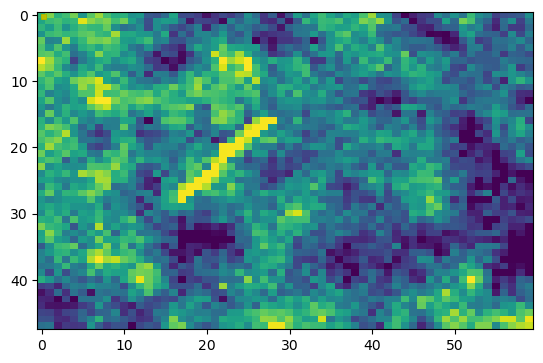

Original BB1: tensor([-0.0368,  0.0824,  0.0904,  0.0041])
Clamped BB1: tensor(0.) tensor(0.0803) tensor(0.0904) tensor(0.0041)
Original BB2: tensor([0.3917, 0.2083, 0.2167, 0.4167])
Clamped BB2: tensor(0.2833) tensor(0.) tensor(0.2167) tensor(0.4167)


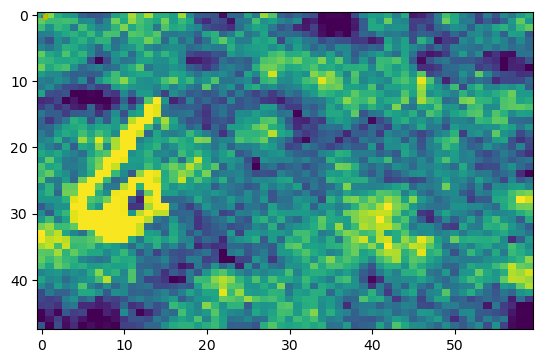

Original BB1: tensor([-0.0370,  0.0783,  0.0862,  0.0016])
Clamped BB1: tensor(0.) tensor(0.0775) tensor(0.0862) tensor(0.0016)
Original BB2: tensor([0.2083, 0.6354, 0.2167, 0.3125])
Clamped BB2: tensor(0.1000) tensor(0.4792) tensor(0.2167) tensor(0.3125)


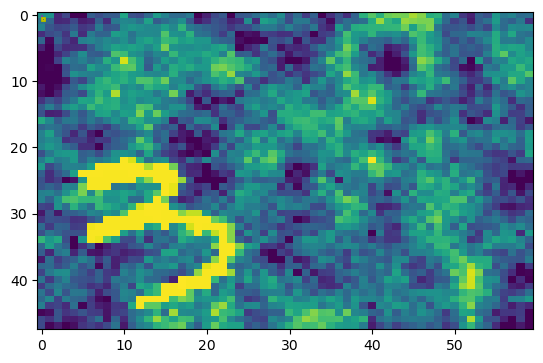

Original BB1: tensor([-0.0348,  0.0782,  0.0882,  0.0014])
Clamped BB1: tensor(0.) tensor(0.0775) tensor(0.0882) tensor(0.0014)
Original BB2: tensor([0.5250, 0.5938, 0.2167, 0.4375])
Clamped BB2: tensor(0.4167) tensor(0.3750) tensor(0.2167) tensor(0.4375)


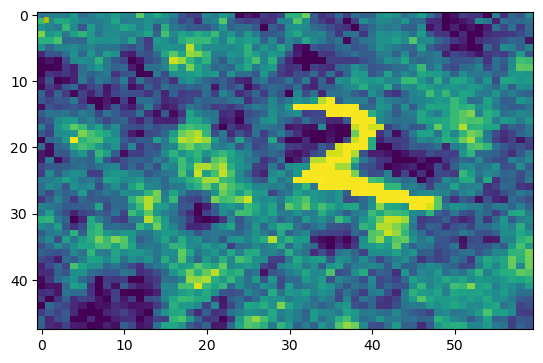

Original BB1: tensor([-0.0367,  0.0777,  0.0880,  0.0033])
Clamped BB1: tensor(0.) tensor(0.0761) tensor(0.0880) tensor(0.0033)
Original BB2: tensor([0.3583, 0.3958, 0.2167, 0.2917])
Clamped BB2: tensor(0.2500) tensor(0.2500) tensor(0.2167) tensor(0.2917)


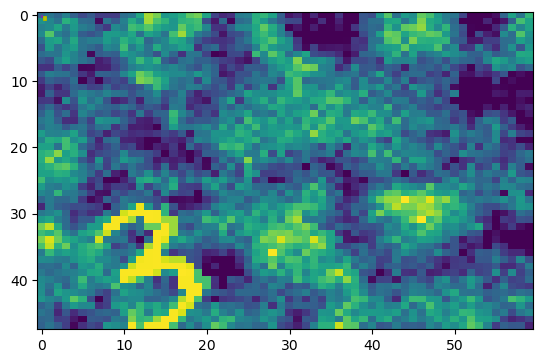

Original BB1: tensor([-0.0355,  0.0779,  0.0852,  0.0024])
Clamped BB1: tensor(0.) tensor(0.0766) tensor(0.0852) tensor(0.0024)
Original BB2: tensor([0.3750, 0.2396, 0.3167, 0.3958])
Clamped BB2: tensor(0.2167) tensor(0.0417) tensor(0.3167) tensor(0.3958)


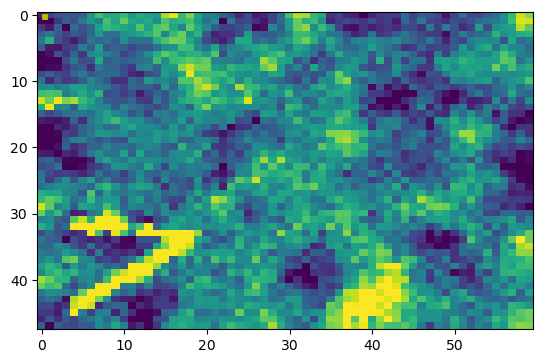

Original BB1: tensor([-0.0339,  0.0751,  0.0894,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0736) tensor(0.0894) tensor(0.0030)
Original BB2: tensor([0.6583, 0.5417, 0.2833, 0.4167])
Clamped BB2: tensor(0.5167) tensor(0.3333) tensor(0.2833) tensor(0.4167)


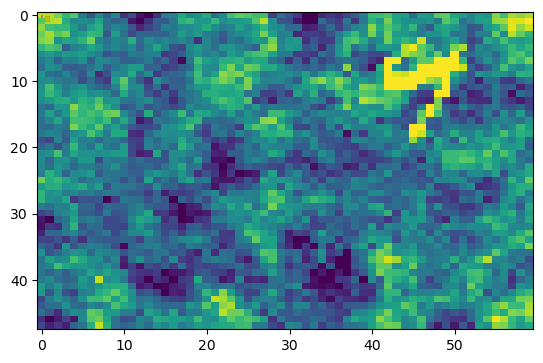

Original BB1: tensor([-0.0358,  0.0770,  0.0897,  0.0038])
Clamped BB1: tensor(0.) tensor(0.0752) tensor(0.0897) tensor(0.0038)
Original BB2: tensor([0.4500, 0.6667, 0.1667, 0.3333])
Clamped BB2: tensor(0.3667) tensor(0.5000) tensor(0.1667) tensor(0.3333)


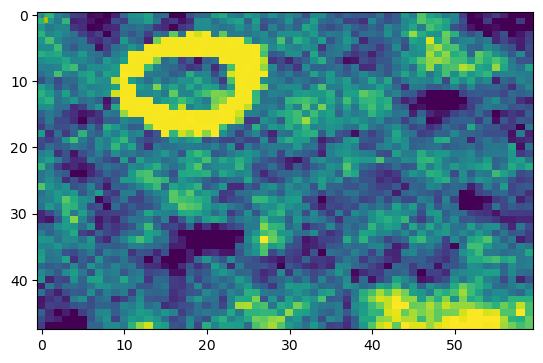

Original BB1: tensor([-0.0370,  0.0765,  0.0877,  0.0035])
Clamped BB1: tensor(0.) tensor(0.0748) tensor(0.0877) tensor(0.0035)
Original BB2: tensor([0.6583, 0.7500, 0.0833, 0.4583])
Clamped BB2: tensor(0.6167) tensor(0.5208) tensor(0.0833) tensor(0.4583)


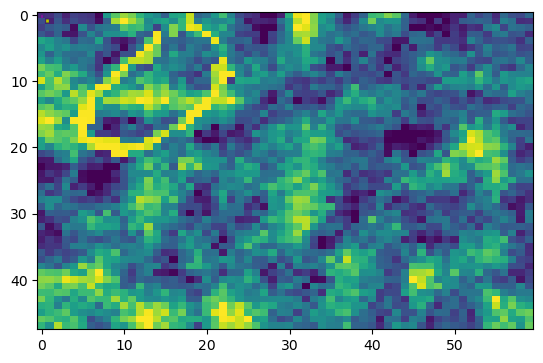

Original BB1: tensor([-0.0356,  0.0798,  0.0861,  0.0036])
Clamped BB1: tensor(0.) tensor(0.0780) tensor(0.0861) tensor(0.0036)
Original BB2: tensor([0.3917, 0.8021, 0.0500, 0.3542])
Clamped BB2: tensor(0.3667) tensor(0.6250) tensor(0.0500) tensor(0.3542)


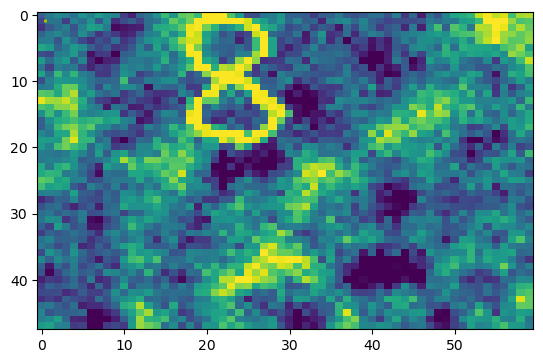

Original BB1: tensor([-0.0362,  0.0793,  0.0881,  0.0036])
Clamped BB1: tensor(0.) tensor(0.0775) tensor(0.0881) tensor(0.0036)
Original BB2: tensor([0.6083, 0.6042, 0.3167, 0.4167])
Clamped BB2: tensor(0.4500) tensor(0.3958) tensor(0.3167) tensor(0.4167)


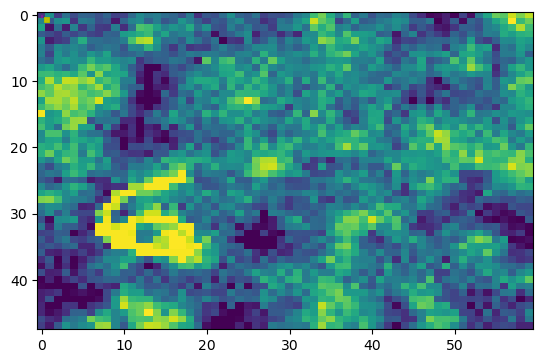

Original BB1: tensor([-0.0376,  0.0801,  0.0861,  0.0041])
Clamped BB1: tensor(0.) tensor(0.0780) tensor(0.0861) tensor(0.0041)
Original BB2: tensor([0.2583, 0.1979, 0.1833, 0.3542])
Clamped BB2: tensor(0.1667) tensor(0.0208) tensor(0.1833) tensor(0.3542)


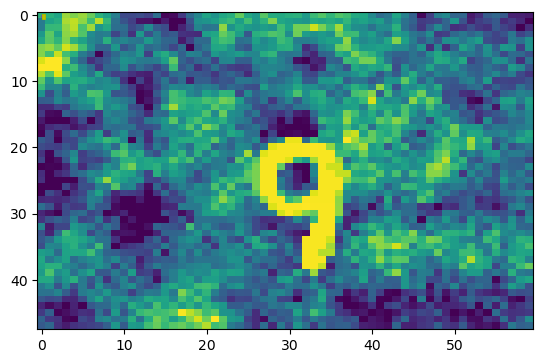

Original BB1: tensor([-0.0384,  0.0794,  0.0886,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0781) tensor(0.0886) tensor(0.0025)
Original BB2: tensor([0.4833, 0.2188, 0.1333, 0.2708])
Clamped BB2: tensor(0.4167) tensor(0.0833) tensor(0.1333) tensor(0.2708)


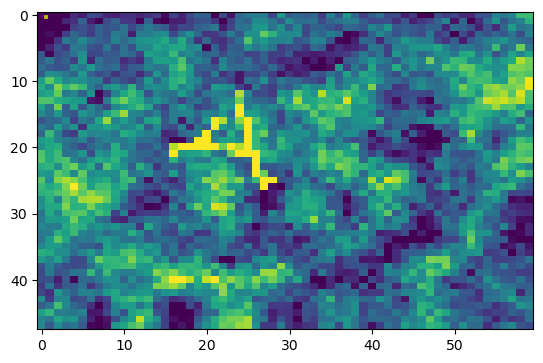

Original BB1: tensor([-0.0379,  0.0816,  0.0866,  0.0049])
Clamped BB1: tensor(0.) tensor(0.0792) tensor(0.0866) tensor(0.0049)
Original BB2: tensor([0.1833, 0.4271, 0.2667, 0.3958])
Clamped BB2: tensor(0.0500) tensor(0.2292) tensor(0.2667) tensor(0.3958)


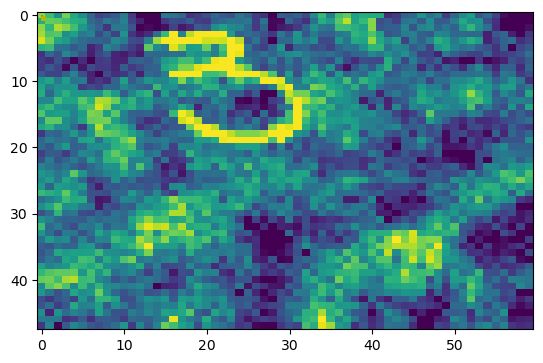

Original BB1: tensor([-0.0365,  0.0791,  0.0867,  0.0024])
Clamped BB1: tensor(0.) tensor(0.0779) tensor(0.0867) tensor(0.0024)
Original BB2: tensor([0.5583, 0.2812, 0.2167, 0.3542])
Clamped BB2: tensor(0.4500) tensor(0.1042) tensor(0.2167) tensor(0.3542)


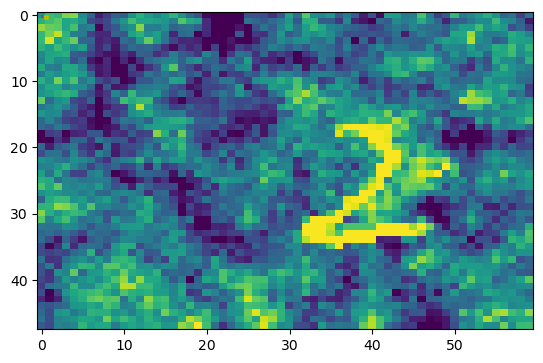

Original BB1: tensor([-0.0370,  0.0788,  0.0860,  0.0023])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0860) tensor(0.0023)
Original BB2: tensor([0.2333, 0.4792, 0.2333, 0.3750])
Clamped BB2: tensor(0.1167) tensor(0.2917) tensor(0.2333) tensor(0.3750)


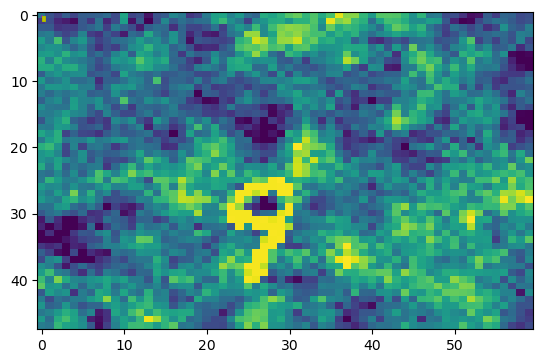

Original BB1: tensor([-0.0368,  0.0782,  0.0873,  0.0028])
Clamped BB1: tensor(0.) tensor(0.0768) tensor(0.0873) tensor(0.0028)
Original BB2: tensor([0.2333, 0.5938, 0.2667, 0.4792])
Clamped BB2: tensor(0.1000) tensor(0.3542) tensor(0.2667) tensor(0.4792)


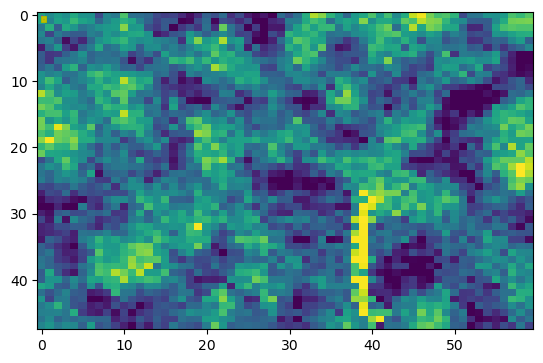

Original BB1: tensor([-0.0376,  0.0796,  0.0884,  0.0050])
Clamped BB1: tensor(0.) tensor(0.0770) tensor(0.0884) tensor(0.0050)
Original BB2: tensor([0.7667, 0.6562, 0.2667, 0.3542])
Clamped BB2: tensor(0.6333) tensor(0.4792) tensor(0.2667) tensor(0.3542)


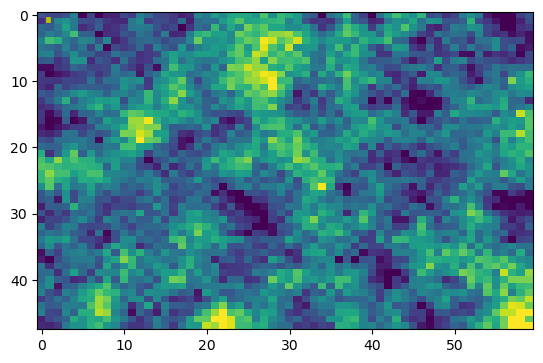

Original BB1: tensor([-0.0363,  0.0797,  0.0849,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0784) tensor(0.0849) tensor(0.0025)
Original BB2: tensor([0.2167, 0.5521, 0.1667, 0.3542])
Clamped BB2: tensor(0.1333) tensor(0.3750) tensor(0.1667) tensor(0.3542)


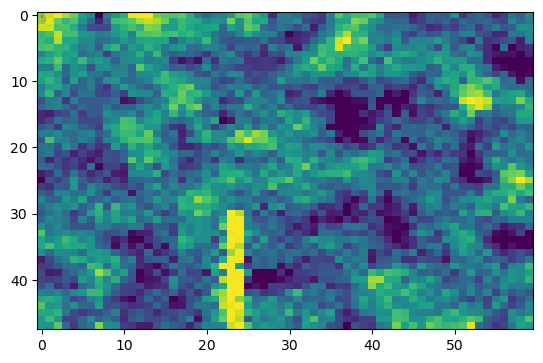

Original BB1: tensor([-0.0355,  0.0799,  0.0892,  0.0054])
Clamped BB1: tensor(0.) tensor(0.0772) tensor(0.0892) tensor(0.0054)
Original BB2: tensor([0.2667, 0.2604, 0.2667, 0.3542])
Clamped BB2: tensor(0.1333) tensor(0.0833) tensor(0.2667) tensor(0.3542)


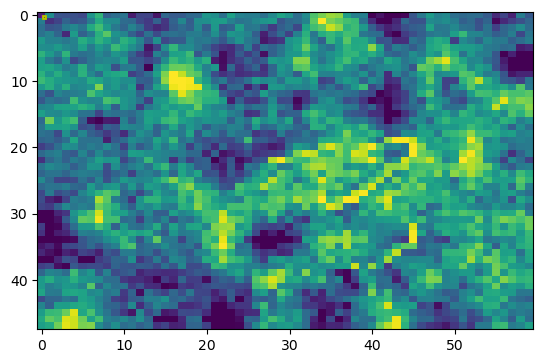

Original BB1: tensor([-0.0362,  0.0789,  0.0874,  0.0032])
Clamped BB1: tensor(0.) tensor(0.0773) tensor(0.0874) tensor(0.0032)
Original BB2: tensor([0.3667, 0.4583, 0.2333, 0.4583])
Clamped BB2: tensor(0.2500) tensor(0.2292) tensor(0.2333) tensor(0.4583)


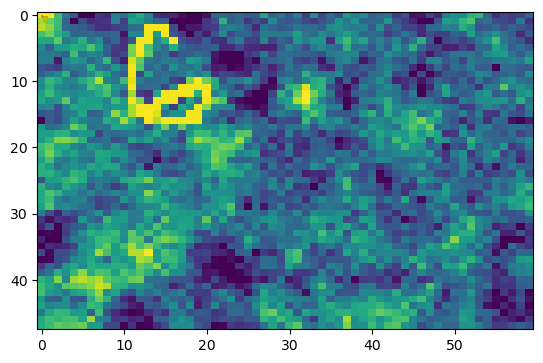

Original BB1: tensor([-0.0377,  0.0809,  0.0886,  0.0045])
Clamped BB1: tensor(0.) tensor(0.0786) tensor(0.0886) tensor(0.0045)
Original BB2: tensor([0.4333, 0.6875, 0.2333, 0.2500])
Clamped BB2: tensor(0.3167) tensor(0.5625) tensor(0.2333) tensor(0.2500)


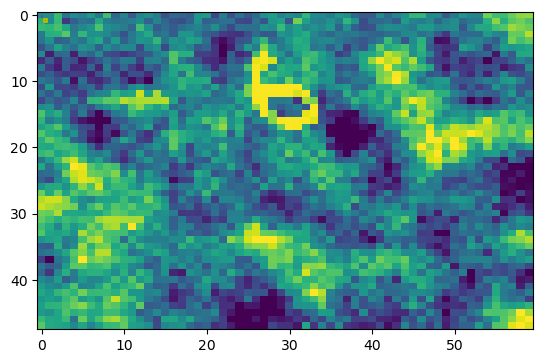

Original BB1: tensor([-0.0363,  0.0775,  0.0864,  0.0019])
Clamped BB1: tensor(0.) tensor(0.0765) tensor(0.0864) tensor(0.0019)
Original BB2: tensor([0.5583, 0.2917, 0.2500, 0.3333])
Clamped BB2: tensor(0.4333) tensor(0.1250) tensor(0.2500) tensor(0.3333)


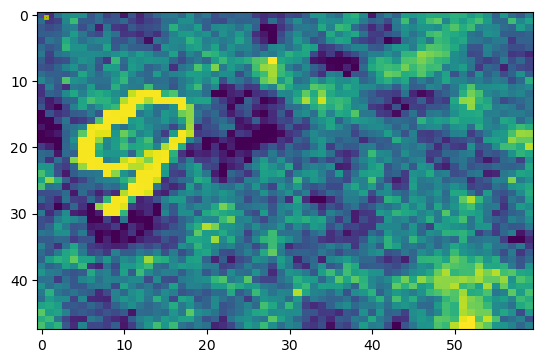

Original BB1: tensor([-0.0364,  0.0799,  0.0858,  0.0021])
Clamped BB1: tensor(0.) tensor(0.0788) tensor(0.0858) tensor(0.0021)
Original BB2: tensor([0.4500, 0.2500, 0.3000, 0.5000])
Clamped BB2: tensor(0.3000) tensor(0.) tensor(0.3000) tensor(0.5000)


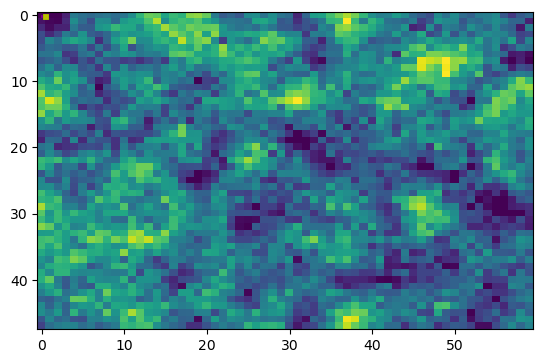

Original BB1: tensor([-0.0365,  0.0785,  0.0886,  0.0026])
Clamped BB1: tensor(0.) tensor(0.0772) tensor(0.0886) tensor(0.0026)
Original BB2: tensor([0.6667, 0.6354, 0.2667, 0.4792])
Clamped BB2: tensor(0.5333) tensor(0.3958) tensor(0.2667) tensor(0.4792)


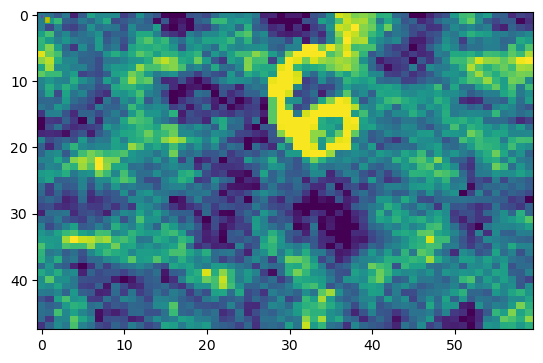

Original BB1: tensor([-0.0360,  0.0791,  0.0887,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0778) tensor(0.0887) tensor(0.0025)
Original BB2: tensor([0.3500, 0.5521, 0.3000, 0.3542])
Clamped BB2: tensor(0.2000) tensor(0.3750) tensor(0.3000) tensor(0.3542)


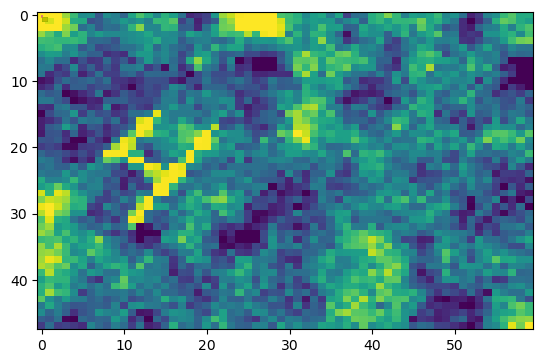

Original BB1: tensor([-0.0361,  0.0781,  0.0892,  0.0031])
Clamped BB1: tensor(0.) tensor(0.0765) tensor(0.0892) tensor(0.0031)
Original BB2: tensor([0.6833, 0.4479, 0.3667, 0.4792])
Clamped BB2: tensor(0.5000) tensor(0.2083) tensor(0.3667) tensor(0.4792)


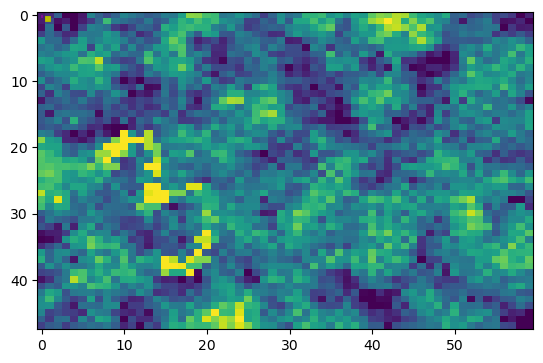

Original BB1: tensor([-0.0356,  0.0784,  0.0854,  0.0029])
Clamped BB1: tensor(0.) tensor(0.0770) tensor(0.0854) tensor(0.0029)
Original BB2: tensor([0.6167, 0.2083, 0.2000, 0.4167])
Clamped BB2: tensor(0.5167) tensor(0.) tensor(0.2000) tensor(0.4167)


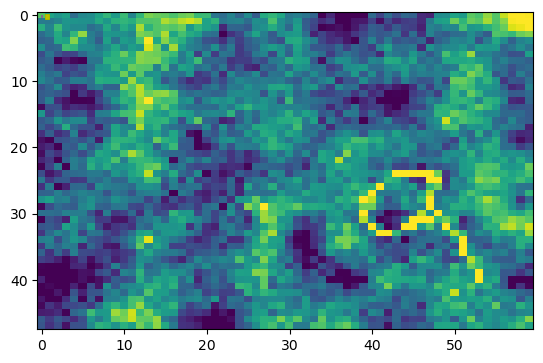

Original BB1: tensor([-0.0379,  0.0805,  0.0860,  0.0033])
Clamped BB1: tensor(0.) tensor(0.0789) tensor(0.0860) tensor(0.0033)
Original BB2: tensor([0.1917, 0.6771, 0.3500, 0.3958])
Clamped BB2: tensor(0.0167) tensor(0.4792) tensor(0.3500) tensor(0.3958)


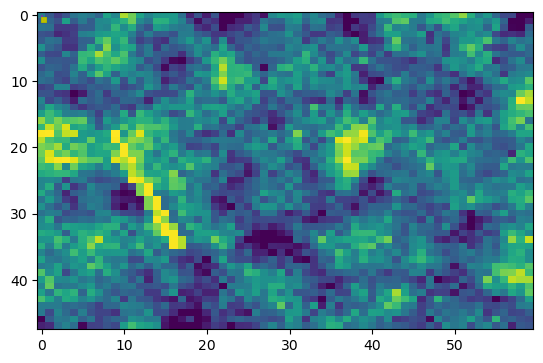

Original BB1: tensor([-0.0369,  0.0794,  0.0867,  0.0019])
Clamped BB1: tensor(0.) tensor(0.0785) tensor(0.0867) tensor(0.0019)
Original BB2: tensor([0.4833, 0.2500, 0.3000, 0.5000])
Clamped BB2: tensor(0.3333) tensor(0.) tensor(0.3000) tensor(0.5000)


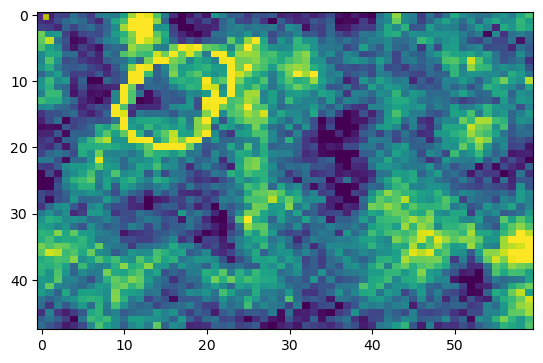

Original BB1: tensor([-0.0367,  0.0803,  0.0869,  0.0018])
Clamped BB1: tensor(0.) tensor(0.0794) tensor(0.0869) tensor(0.0018)
Original BB2: tensor([0.7917, 0.2500, 0.3500, 0.4583])
Clamped BB2: tensor(0.6167) tensor(0.0208) tensor(0.3500) tensor(0.4583)


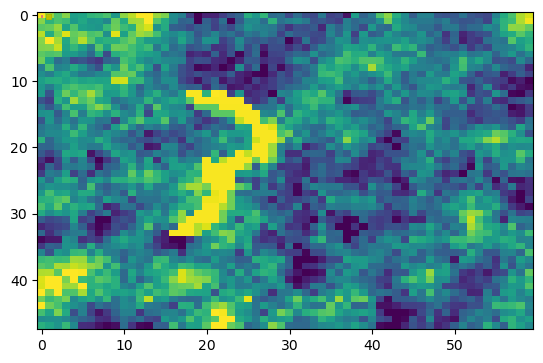

Original BB1: tensor([-0.0367,  0.0789,  0.0865,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0774) tensor(0.0865) tensor(0.0030)
Original BB2: tensor([0.2667, 0.6562, 0.1667, 0.3958])
Clamped BB2: tensor(0.1833) tensor(0.4583) tensor(0.1667) tensor(0.3958)


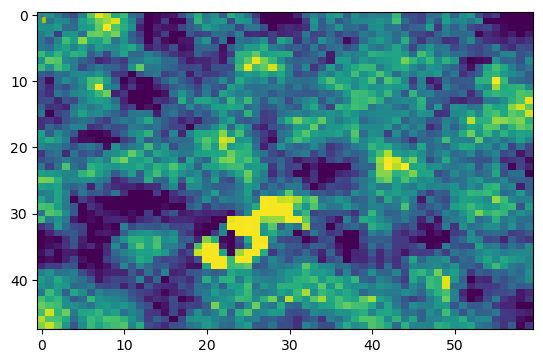

Original BB1: tensor([-0.0362,  0.0793,  0.0879,  0.0038])
Clamped BB1: tensor(0.) tensor(0.0773) tensor(0.0879) tensor(0.0038)
Original BB2: tensor([0.8250, 0.5521, 0.2500, 0.3542])
Clamped BB2: tensor(0.7000) tensor(0.3750) tensor(0.2500) tensor(0.3542)


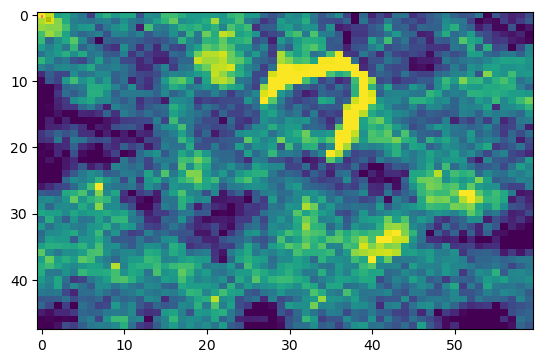

Original BB1: tensor([-0.0333,  0.0770,  0.0897,  0.0030])
Clamped BB1: tensor(0.) tensor(0.0755) tensor(0.0897) tensor(0.0030)
Original BB2: tensor([0.4583, 0.3021, 0.4167, 0.4375])
Clamped BB2: tensor(0.2500) tensor(0.0833) tensor(0.4167) tensor(0.4375)


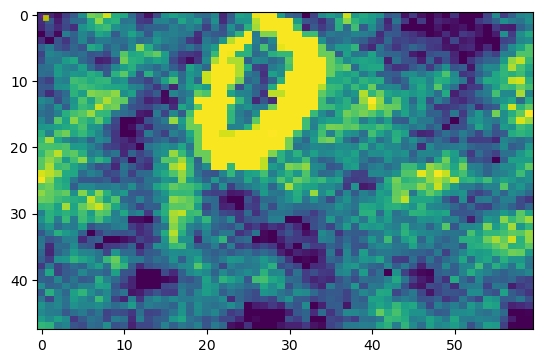

Original BB1: tensor([-0.0380,  0.0793,  0.0885,  0.0032])
Clamped BB1: tensor(0.) tensor(0.0777) tensor(0.0885) tensor(0.0032)
Original BB2: tensor([0.3083, 0.4792, 0.2833, 0.4583])
Clamped BB2: tensor(0.1667) tensor(0.2500) tensor(0.2833) tensor(0.4583)


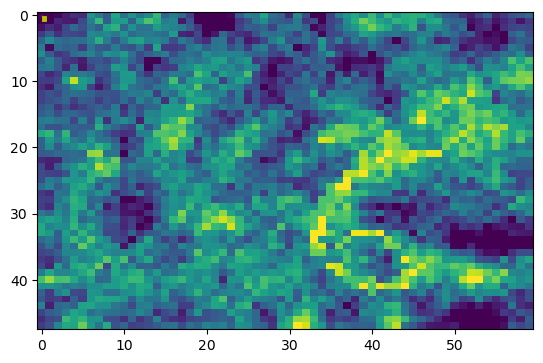

Original BB1: tensor([-0.0364,  0.0787,  0.0883,  0.0041])
Clamped BB1: tensor(0.) tensor(0.0767) tensor(0.0883) tensor(0.0041)
Original BB2: tensor([0.3500, 0.5312, 0.2667, 0.3958])
Clamped BB2: tensor(0.2167) tensor(0.3333) tensor(0.2667) tensor(0.3958)


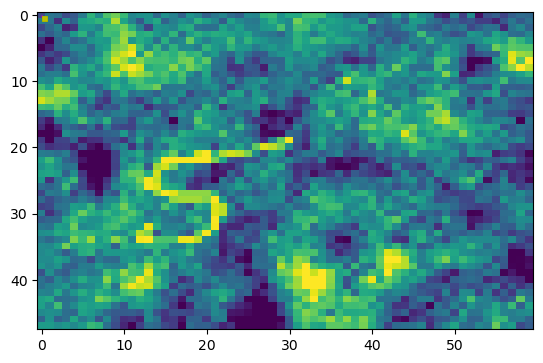

Original BB1: tensor([-0.0378,  0.0820,  0.0871,  0.0031])
Clamped BB1: tensor(0.) tensor(0.0805) tensor(0.0871) tensor(0.0031)
Original BB2: tensor([0.5750, 0.3125, 0.1500, 0.3333])
Clamped BB2: tensor(0.5000) tensor(0.1458) tensor(0.1500) tensor(0.3333)


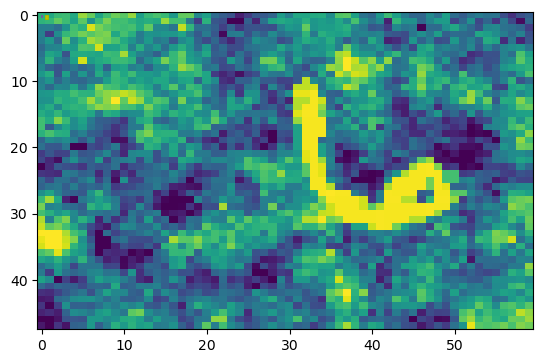

Original BB1: tensor([-0.0376,  0.0809,  0.0890,  0.0024])
Clamped BB1: tensor(0.) tensor(0.0797) tensor(0.0890) tensor(0.0024)
Original BB2: tensor([0.6250, 0.3750, 0.2167, 0.3750])
Clamped BB2: tensor(0.5167) tensor(0.1875) tensor(0.2167) tensor(0.3750)


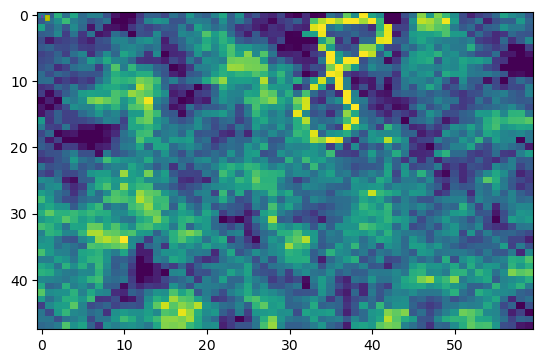

Original BB1: tensor([-0.0365,  0.0789,  0.0886,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0776) tensor(0.0886) tensor(0.0025)
Original BB2: tensor([0.5917, 0.7083, 0.3167, 0.3750])
Clamped BB2: tensor(0.4333) tensor(0.5208) tensor(0.3167) tensor(0.3750)


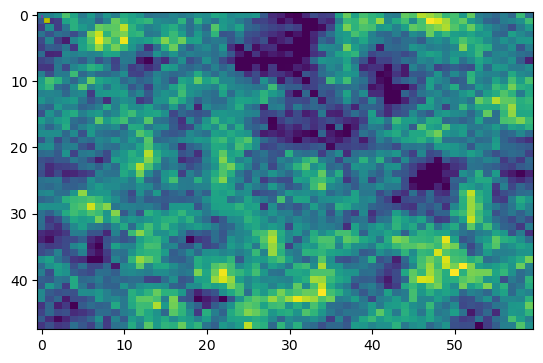

Original BB1: tensor([-0.0368,  0.0777,  0.0899,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0765) tensor(0.0899) tensor(0.0025)
Original BB2: tensor([0.2667, 0.6354, 0.1667, 0.2708])
Clamped BB2: tensor(0.1833) tensor(0.5000) tensor(0.1667) tensor(0.2708)


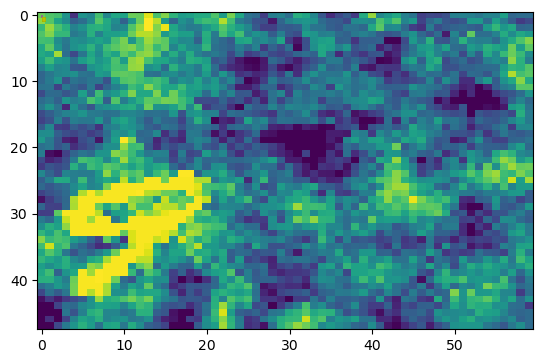

Original BB1: tensor([-0.0357,  0.0788,  0.0855,  0.0034])
Clamped BB1: tensor(0.) tensor(0.0771) tensor(0.0855) tensor(0.0034)
Original BB2: tensor([0.6833, 0.6354, 0.1000, 0.3958])
Clamped BB2: tensor(0.6333) tensor(0.4375) tensor(0.1000) tensor(0.3958)


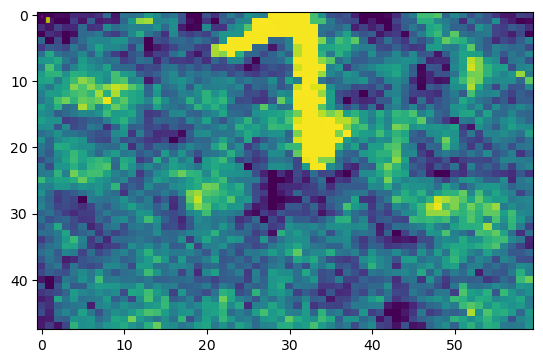

Original BB1: tensor([-0.0360,  0.0796,  0.0893,  0.0027])
Clamped BB1: tensor(0.) tensor(0.0783) tensor(0.0893) tensor(0.0027)
Original BB2: tensor([0.3750, 0.4792, 0.2833, 0.3333])
Clamped BB2: tensor(0.2333) tensor(0.3125) tensor(0.2833) tensor(0.3333)


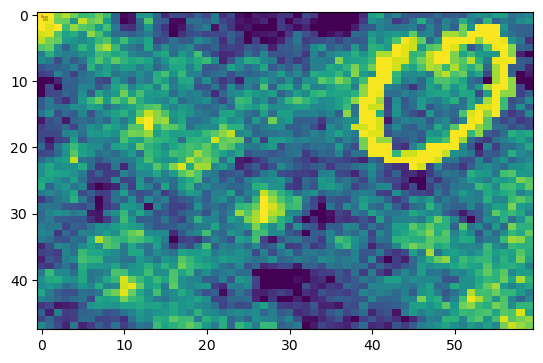

Original BB1: tensor([-0.0372,  0.0809,  0.0870,  0.0025])
Clamped BB1: tensor(0.) tensor(0.0796) tensor(0.0870) tensor(0.0025)
Original BB2: tensor([0.1833, 0.5833, 0.3333, 0.4167])
Clamped BB2: tensor(0.0167) tensor(0.3750) tensor(0.3333) tensor(0.4167)


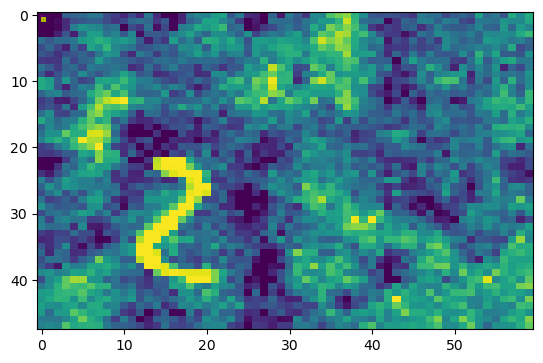

Original BB1: tensor([-0.0372,  0.0799,  0.0875,  0.0034])
Clamped BB1: tensor(0.) tensor(0.0782) tensor(0.0875) tensor(0.0034)
Original BB2: tensor([0.5583, 0.2083, 0.2167, 0.3333])
Clamped BB2: tensor(0.4500) tensor(0.0417) tensor(0.2167) tensor(0.3333)


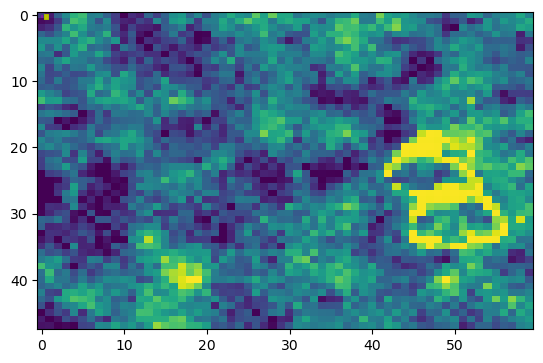

IndexError: index 116 is out of bounds for dimension 0 with size 116

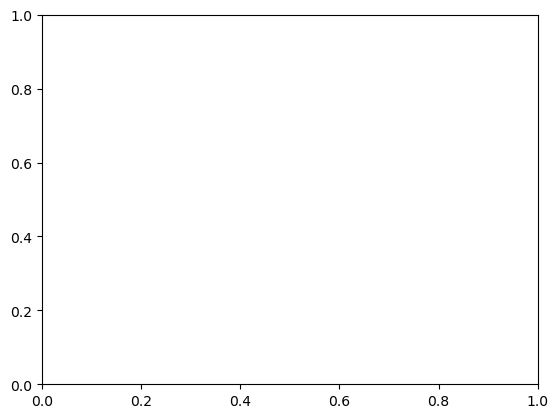

In [115]:
compute_accuracy(model_1, val_loader)


# Object detection

In [70]:
detection_train_data = torch.load("list_y_true_train.pt") 
detection_val_data = torch.load("list_y_true_val.pt")
detection_test_data= torch.load("list_y_true_test.pt")